# 新段落

In [ ]:
import torch
from sklearn.datasets import make_moons
from torch import nn, optim, distributions
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, load_digits
from sklearn.model_selection import train_test_split
import numpy as np
from torchvision.transforms.functional import rotate
from scipy import ndimage
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F



***TASK 1

Two moons with an invertible neural network

We repeat task 2 from exercise 02 with a normalizing
ow. That is, use a RealNVP network to train a generative model p(x) for the two moons dataset. A RealNVP consists of coupling blocks, where the second half of the dimensions is transformed by a linear function whose coe
cients depend on the
rst half. The coe
cients are calculated with nested neural networks with two hidden layers (with ReLU activation) and a linear output layer (for the translation coe
cient) resp. a linear layer followed by exp(tanh(˜s)) (for the scaling coe
cient). The width of these internal networks is a hyperparameter and may be larger than the data dimension. The
rst half of the dimensions is just forwared by a skip connection. After each coupling layer (except for the last), a random orthogonormal matrix is inserted to rotate the space, so that the skip connection is not always applied to the same dimensions. The RealNVP's constructor should have three arguments:

input_size: the data dimension (= 2 for the two moons dataset) hidden_size: the width of the nested networks

blocks: the number of coupling blocks

Implement the encoder as the forward pass through the network, and the decoder as the reverse pass. Furthermore, implement a training function train_inn() (for invertible neural network) using the torch.optim.Adam optimizer with default learning rate lr=0.001 and the negative log-likelihood loss, as explained in the lecture. Training has again three hyperparameters: the size of the training set, the number of epochs, and the learning rate. ***

In [ ]:
# Define constants
INPUT_DIM = 2  # Two moons dataset has 2 dimensions
OUTPUT_DIM = INPUT_DIM  # Output dimension is same as input
HIDDEN_DIM = 256  # Hidden layer size (can be tuned)
N_COUPLE_LAYERS = 6  # Number of coupling layers
EPOCHS = 100  # Number of training epochs
LOG_INTERVAL = 10  # Logging interval
SAVE_PLT_INTERVAL = 20  # Interval for saving plots

In [ ]:
# Assuming device configuration (CPU or CUDA)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# --- defines the model and the optimizer ---- #
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask):
        super(CouplingLayer, self).__init__()
        self.s_fc1 = nn.Linear(input_dim, hid_dim)
        self.s_fc2 = nn.Linear(hid_dim, hid_dim)
        self.s_fc3 = nn.Linear(hid_dim, output_dim)
        self.t_fc1 = nn.Linear(input_dim, hid_dim)
        self.t_fc2 = nn.Linear(hid_dim, hid_dim)
        self.t_fc3 = nn.Linear(hid_dim, output_dim)
        self.register_buffer('mask', mask)

    def forward(self, x):
        x_m = x * self.mask
        s_out = torch.tanh(self.s_fc3(F.relu(self.s_fc2(F.relu(self.s_fc1(x_m))))))
        t_out = self.t_fc3(F.relu(self.t_fc2(F.relu(self.t_fc1(x_m)))))
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)
        return y, log_det_jacobian

    def backward(self, y):
        y_m = y * self.mask
        s_out = torch.tanh(self.s_fc3(F.relu(self.s_fc2(F.relu(self.s_fc1(y_m))))))
        t_out = self.t_fc3(F.relu(self.t_fc2(F.relu(self.t_fc1(y_m)))))
        x = y_m + (1-self.mask)*(y-t_out)*torch.exp(-s_out)
        return x


class RealNVP(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask, n_layers = 6):
        super().__init__()
        assert n_layers >= 2, 'num of coupling layers should be greater or equal to 2'

        self.modules = []
        self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
        self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0 # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj= module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def backward(self, z):
        for module in reversed(self.module_list):
            z = module.backward(z)
        return z




In [ ]:
def import_data(noise=0, random_state=1, shuffle=True, n_test=0.5, name="moons", n_samples = 2000):
    if name == "moons":
        data, _ = make_moons(noise=noise, random_state=random_state, shuffle=shuffle, n_samples=n_samples)
        #data = StandardScaler().fit_transform(data)
        X_train, X_test= train_test_split(data, test_size=n_test, random_state=random_state)
        return torch.FloatTensor(X_train), torch.FloatTensor(X_test), None, None

    elif name == "digits":
        data, labels = load_digits(return_X_y = True)
        data = data.reshape((len(data), -1))
        data = StandardScaler().fit_transform(data)
        noise =  np.random.normal(0, noise * data.max(), data.shape)


# Use the import_data function to load the dataset
X_train, X_test, _, _ = import_data(noise=0.1, n_samples=2000, name="moons")

# Convert data to DataLoader if necessary
train_loader = torch.utils.data.DataLoader(X_train, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=128)



In [ ]:
# Instantiate the model, optimizer, and prior
X_train, X_test, _, _ = import_data(noise=0.1, n_samples=2000, name="moons")
train_loader = torch.utils.data.DataLoader(X_train, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=128)
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, mask, N_COUPLE_LAYERS)
model=model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(INPUT_DIM, device=device), torch.eye(INPUT_DIM, device=device))

In [ ]:
# --- train and test --- #
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data=data.to(device)
        optimizer.zero_grad()
        z, log_det_j_sum = model(data)
        loss = -(prior_z.log_prob(z)+log_det_j_sum).mean()
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100.*batch_idx / len(train_loader),
                cur_loss/len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)
    ))



def test(epoch):
    if epoch % 10 == 0:  # Check if the current epoch is a multiple of 10
        model.eval()
        test_loss = 0
        x_all = np.array([[]]).reshape(0, 2)
        z_all = np.array([[]]).reshape(0, 2)
        with torch.no_grad():
            for batch_idx, data in enumerate(test_loader):
                data = data.to(device)
                z, log_det_j_sum = model(data)
                cur_loss = -(prior_z.log_prob(z) + log_det_j_sum).mean().item()
                test_loss += cur_loss

                # Move tensors to CPU for plotting
                x_all = np.concatenate((x_all, data.cpu().numpy()))
                z_all = np.concatenate((z_all, z.cpu().numpy()))

            test_loss /= len(test_loader.dataset)
            print('====> Test set loss: {:.4f}'.format(test_loss))

            # Plotting
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(x_all[:, 0], x_all[:, 1], color='blue', label='Real Data')
            plt.title("Real Data")
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.scatter(z_all[:, 0], z_all[:, 1], color='red', label='Transformed Data')
            plt.title("Transformed Data")
            plt.legend()

            plt.show()


In [ ]:
def sample(epoch):
    if epoch % 10 == 0:  # Check if the current epoch is a multiple of 10
        model.eval()
        with torch.no_grad():
            z = prior_z.sample((1000,)).to(device)  # Generate z samples
            x = model.backward(z).cpu().numpy()    # Generate synthetic data and move to CPU
            z = z.cpu().numpy()                    # Move z to CPU for plotting

            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(z[:, 0], z[:, 1], color='red', label='z - Latent Space')
            plt.title("Latent Space")
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.scatter(x[:, 0], x[:, 1], color='blue', label='x - Generated Data')
            plt.title("Generated Data")
            plt.legend()

            plt.show()

In [ ]:
def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
        if location == 1:
            plt.clf()
        plt.subplot(2,2,location)
        plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
        plt.xlim(x_start,x_end)
        plt.ylim(y_start,y_end)
        plt.title(title)
        plt.pause(1e-2)

In [ ]:
## MMD computation:
def squared_distances(X, Y):
    """
    Compute the squared Euclidean distances between each pair of points in the two datasets X and Y.

    :param X: Array of shape (n_samples_X, n_features).
    :param Y: Array of shape (n_samples_Y, n_features).
    :return: Matrix of shape (n_samples_X, n_samples_Y) where each element represents the squared distance.
    """
    # Expand the squares of X and Y
    X_square = torch.sum(X**2, dim=1, keepdim=True)
    Y_square = torch.sum(Y**2, dim=1, keepdim=True)

    # Compute the squared distances
    squared_dist = X_square - 2 * torch.matmul(X, Y.t()) + Y_square.t()
    return squared_dist

def se_kernel_custom(X, Y, gamma=None):
    """
    Compute the Radial Basis Function (RBF) kernel (squared exponential) between each pair of points in X and Y.

    :param X: First dataset.
    :param Y: Second dataset.
    :param gamma: Gamma parameter for the RBF kernel. If None, it's set to 1/n_features.
    :return: RBF kernel matrix.
    """
    if gamma is None:
        gamma = 1.0 / X.shape[1]  # 1/n_features

    sq_dists = squared_distances(X, Y)
    return torch.exp(-gamma * sq_dists)

def compute_mmd(kernel_XX, kernel_YY, kernel_XY):
    """
    Compute the MMD value from the kernel matrices.
    :param kernel_XX: Kernel matrix among samples in X.
    :param kernel_YY: Kernel matrix among samples in Y.
    :param kernel_XY: Kernel matrix between samples in X and Y.
    :return: MMD value.
    """
    mmd_square = torch.mean(kernel_XX) + torch.mean(kernel_YY) - 2 * torch.mean(kernel_XY)
    return torch.sqrt(mmd_square)  # Return the square root to get MMD


In [ ]:
def report_mmd():
    model.eval()
    with torch.no_grad():
        # Generate synthetic data
        z = prior_z.sample((len(X_test),))  # Sample z from the prior
        synthetic_data = model.backward(z.to(device)).cpu()  # Generate synthetic data

        # Convert test data to tensor
        test_data_tensor = torch.tensor(X_test, dtype=torch.float32)

        # Compute the kernel matrices
        kernel_XX = se_kernel_custom(test_data_tensor, test_data_tensor)
        kernel_YY = se_kernel_custom(synthetic_data, synthetic_data)
        kernel_XY = se_kernel_custom(test_data_tensor, synthetic_data)

        # Compute MMD
        mmd_value = compute_mmd(kernel_XX, kernel_YY, kernel_XY)
        print("MMD Value:", mmd_value.item())

        # Optional: Visualize the real and synthetic data
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(X_test[:, 0], X_test[:, 1], color='blue', label='Real Data')
        plt.title("Real Data")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.scatter(synthetic_data[:, 0].numpy(), synthetic_data[:, 1].numpy(), color='red', label='Synthetic Data')
        plt.title("Synthetic Data")
        plt.legend()
        plt.show()


Train Epoch: 1 [0/1000 (0%)]	Loss: -0.037287
====> Epoch: 1 Average loss: -0.0388
Train Epoch: 2 [0/1000 (0%)]	Loss: -0.038991
====> Epoch: 2 Average loss: -0.0389
Train Epoch: 3 [0/1000 (0%)]	Loss: -0.038089
====> Epoch: 3 Average loss: -0.0387
Train Epoch: 4 [0/1000 (0%)]	Loss: -0.038353
====> Epoch: 4 Average loss: -0.0393
Train Epoch: 5 [0/1000 (0%)]	Loss: -0.038224
====> Epoch: 5 Average loss: -0.0393
Train Epoch: 6 [0/1000 (0%)]	Loss: -0.038524
====> Epoch: 6 Average loss: -0.0394
Train Epoch: 7 [0/1000 (0%)]	Loss: -0.038506
====> Epoch: 7 Average loss: -0.0392
Train Epoch: 8 [0/1000 (0%)]	Loss: -0.038880
====> Epoch: 8 Average loss: -0.0393
Train Epoch: 9 [0/1000 (0%)]	Loss: -0.037877
====> Epoch: 9 Average loss: -0.0392
Train Epoch: 10 [0/1000 (0%)]	Loss: -0.038208
====> Epoch: 10 Average loss: -0.0392
====> Test set loss: -0.0385


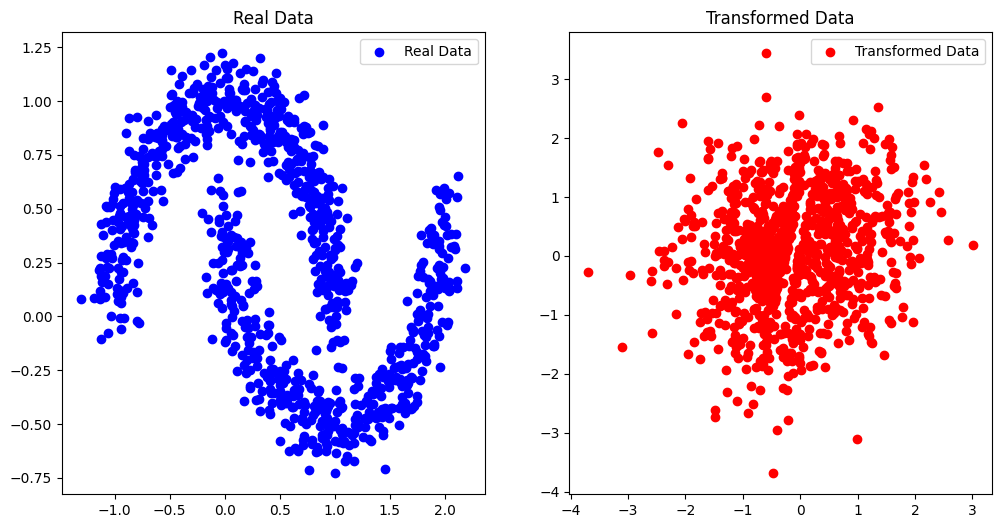

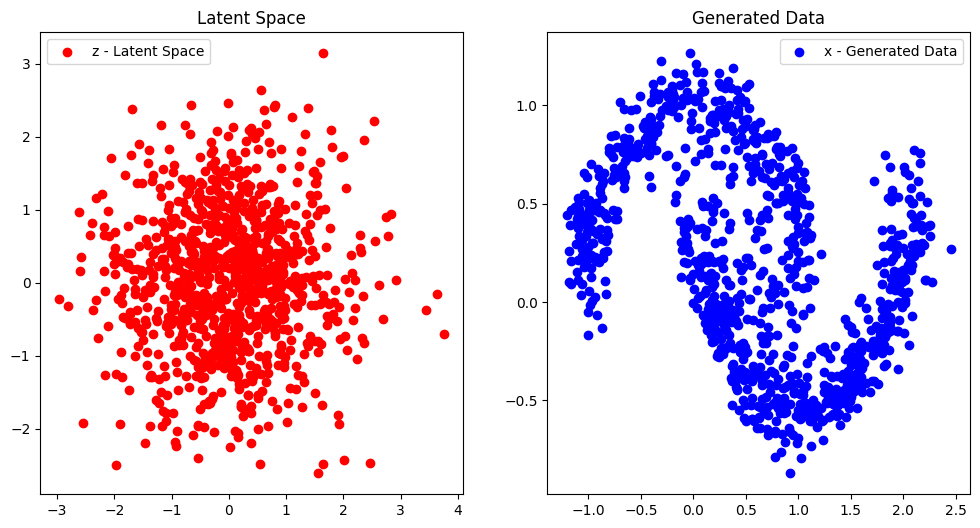

<ipython-input-54-5e48e30a5824>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data_tensor = torch.tensor(X_test, dtype=torch.float32)


MMD Value: 0.08438264578580856


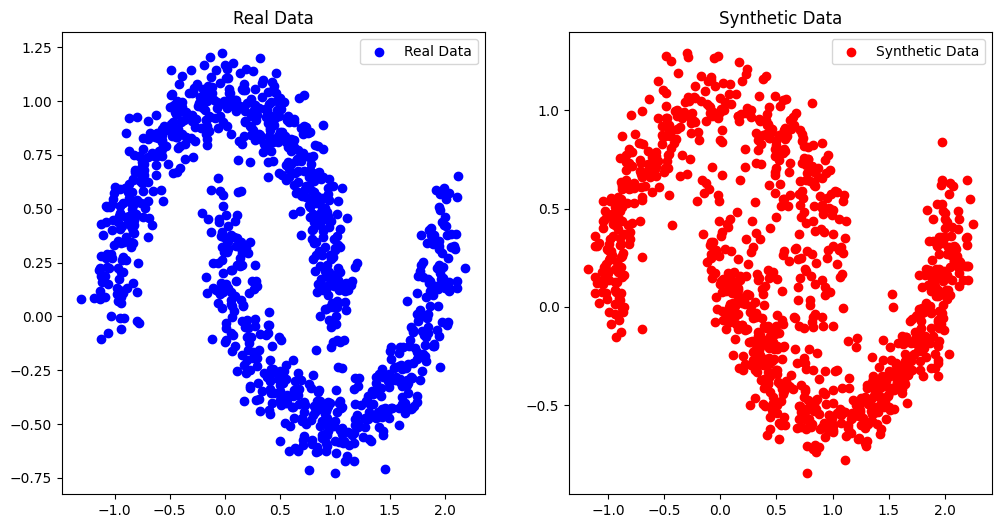

Train Epoch: 11 [0/1000 (0%)]	Loss: -0.038747
====> Epoch: 11 Average loss: -0.0392
Train Epoch: 12 [0/1000 (0%)]	Loss: -0.038540
====> Epoch: 12 Average loss: -0.0392
Train Epoch: 13 [0/1000 (0%)]	Loss: -0.038215
====> Epoch: 13 Average loss: -0.0391
Train Epoch: 14 [0/1000 (0%)]	Loss: -0.038784
====> Epoch: 14 Average loss: -0.0390
Train Epoch: 15 [0/1000 (0%)]	Loss: -0.038175
====> Epoch: 15 Average loss: -0.0393
Train Epoch: 16 [0/1000 (0%)]	Loss: -0.038580
====> Epoch: 16 Average loss: -0.0392
Train Epoch: 17 [0/1000 (0%)]	Loss: -0.038561
====> Epoch: 17 Average loss: -0.0393
Train Epoch: 18 [0/1000 (0%)]	Loss: -0.038429
====> Epoch: 18 Average loss: -0.0392
Train Epoch: 19 [0/1000 (0%)]	Loss: -0.038437
====> Epoch: 19 Average loss: -0.0392
Train Epoch: 20 [0/1000 (0%)]	Loss: -0.038213
====> Epoch: 20 Average loss: -0.0392
====> Test set loss: -0.0386


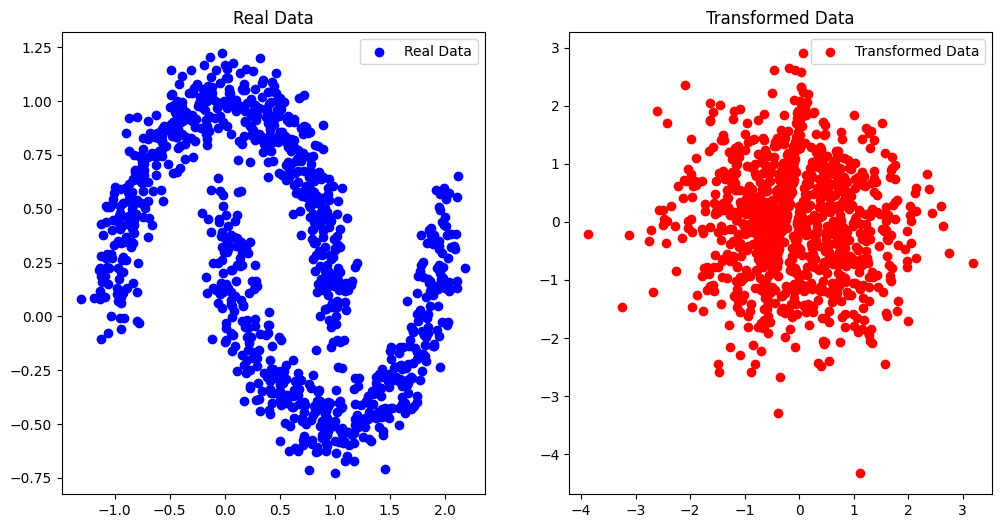

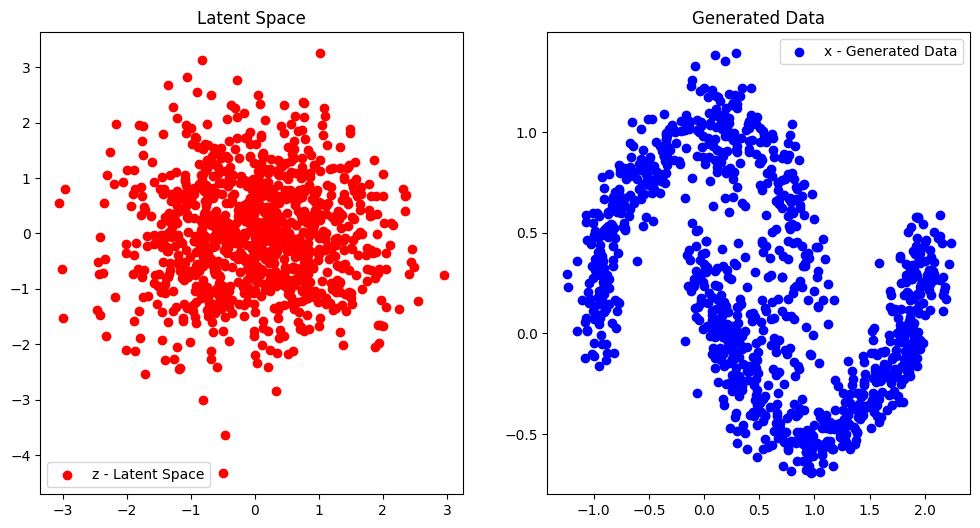

MMD Value: 0.03411859646439552


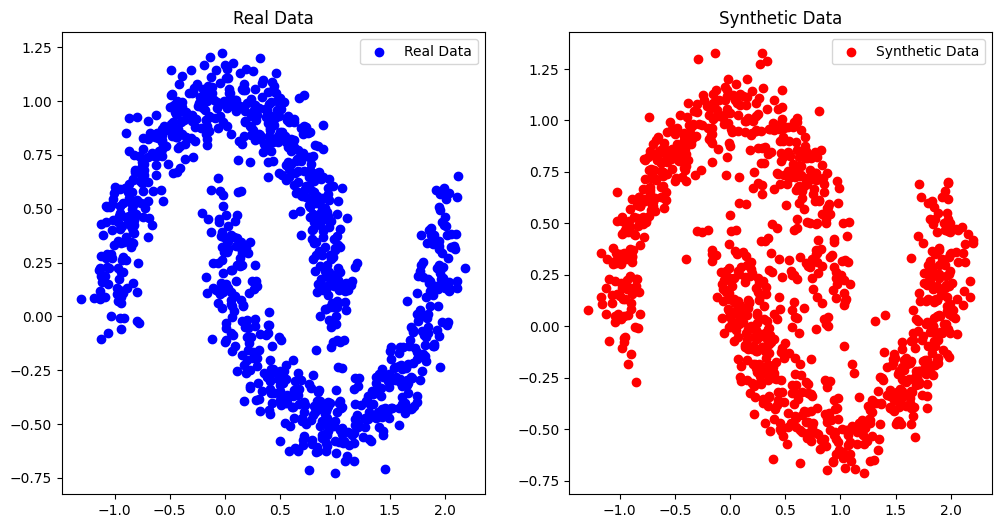

Train Epoch: 21 [0/1000 (0%)]	Loss: -0.038232
====> Epoch: 21 Average loss: -0.0393
Train Epoch: 22 [0/1000 (0%)]	Loss: -0.038686
====> Epoch: 22 Average loss: -0.0395
Train Epoch: 23 [0/1000 (0%)]	Loss: -0.038093
====> Epoch: 23 Average loss: -0.0392
Train Epoch: 24 [0/1000 (0%)]	Loss: -0.038533
====> Epoch: 24 Average loss: -0.0393
Train Epoch: 25 [0/1000 (0%)]	Loss: -0.039239
====> Epoch: 25 Average loss: -0.0394
Train Epoch: 26 [0/1000 (0%)]	Loss: -0.039224
====> Epoch: 26 Average loss: -0.0394
Train Epoch: 27 [0/1000 (0%)]	Loss: -0.037888
====> Epoch: 27 Average loss: -0.0394
Train Epoch: 28 [0/1000 (0%)]	Loss: -0.038713
====> Epoch: 28 Average loss: -0.0395
Train Epoch: 29 [0/1000 (0%)]	Loss: -0.038736
====> Epoch: 29 Average loss: -0.0394
Train Epoch: 30 [0/1000 (0%)]	Loss: -0.037547
====> Epoch: 30 Average loss: -0.0393
====> Test set loss: -0.0386


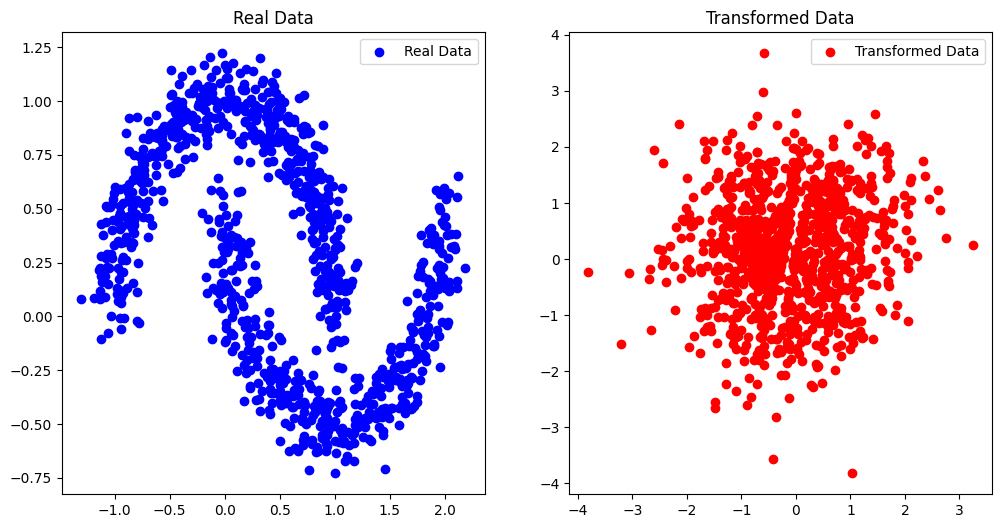

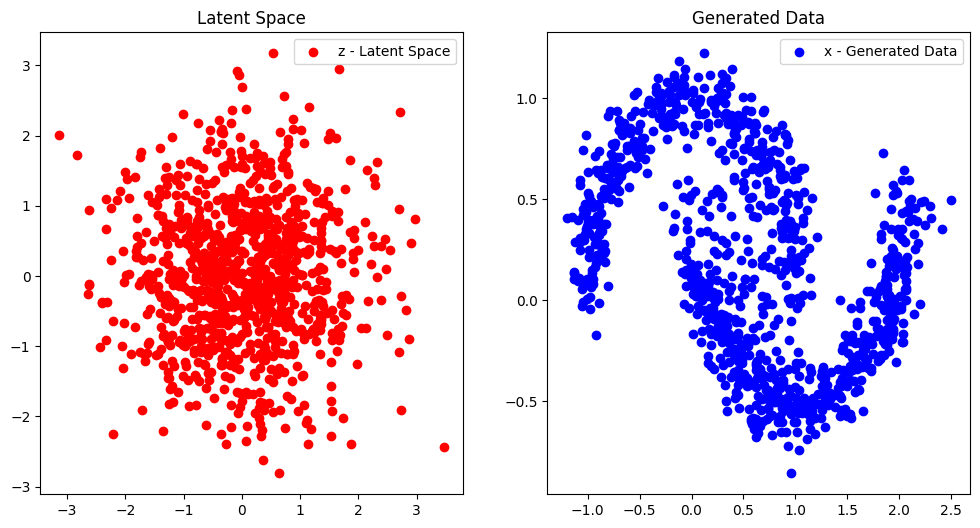

MMD Value: 0.053428322076797485


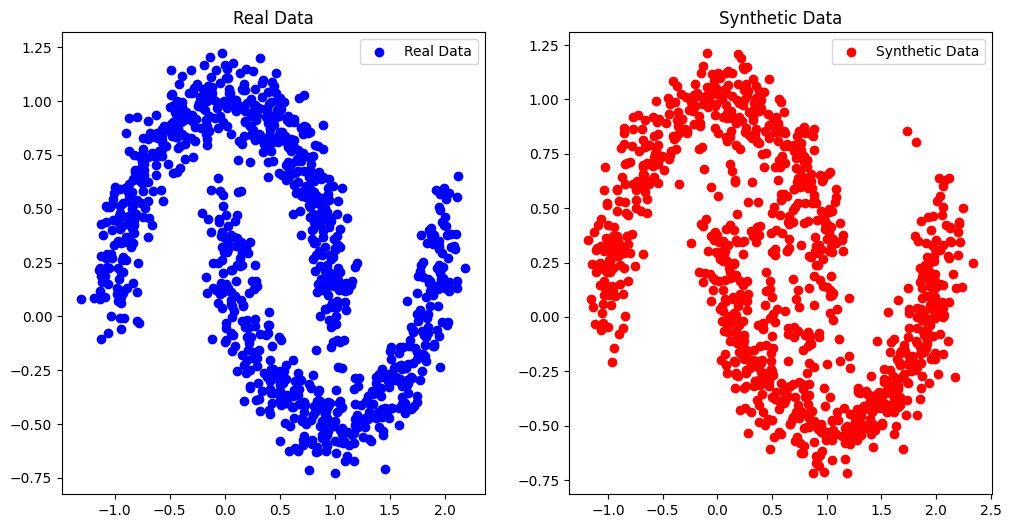

Train Epoch: 31 [0/1000 (0%)]	Loss: -0.039295
====> Epoch: 31 Average loss: -0.0392
Train Epoch: 32 [0/1000 (0%)]	Loss: -0.038801
====> Epoch: 32 Average loss: -0.0391
Train Epoch: 33 [0/1000 (0%)]	Loss: -0.038709
====> Epoch: 33 Average loss: -0.0393
Train Epoch: 34 [0/1000 (0%)]	Loss: -0.038469
====> Epoch: 34 Average loss: -0.0394
Train Epoch: 35 [0/1000 (0%)]	Loss: -0.038867
====> Epoch: 35 Average loss: -0.0394
Train Epoch: 36 [0/1000 (0%)]	Loss: -0.039082
====> Epoch: 36 Average loss: -0.0394
Train Epoch: 37 [0/1000 (0%)]	Loss: -0.038348
====> Epoch: 37 Average loss: -0.0395
Train Epoch: 38 [0/1000 (0%)]	Loss: -0.038402
====> Epoch: 38 Average loss: -0.0394
Train Epoch: 39 [0/1000 (0%)]	Loss: -0.038049
====> Epoch: 39 Average loss: -0.0393
Train Epoch: 40 [0/1000 (0%)]	Loss: -0.038540
====> Epoch: 40 Average loss: -0.0393
====> Test set loss: -0.0386


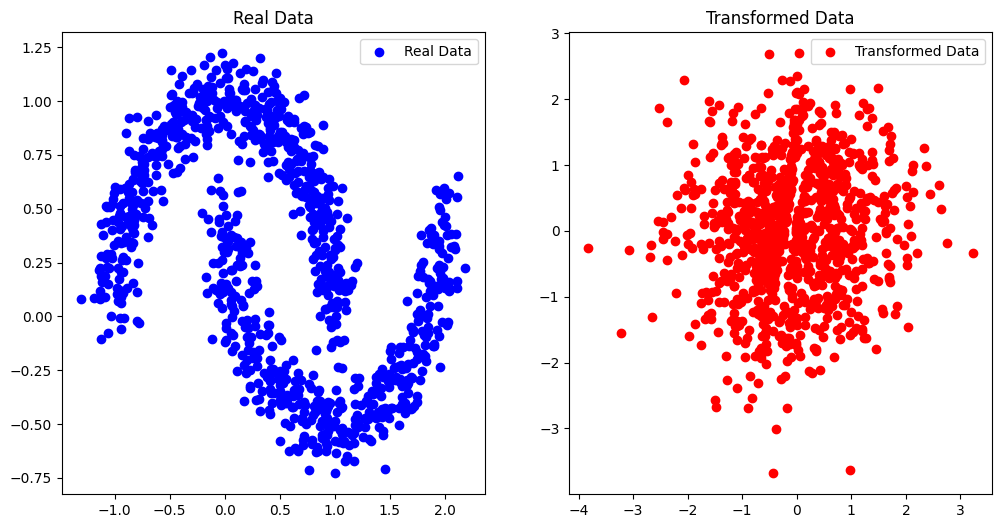

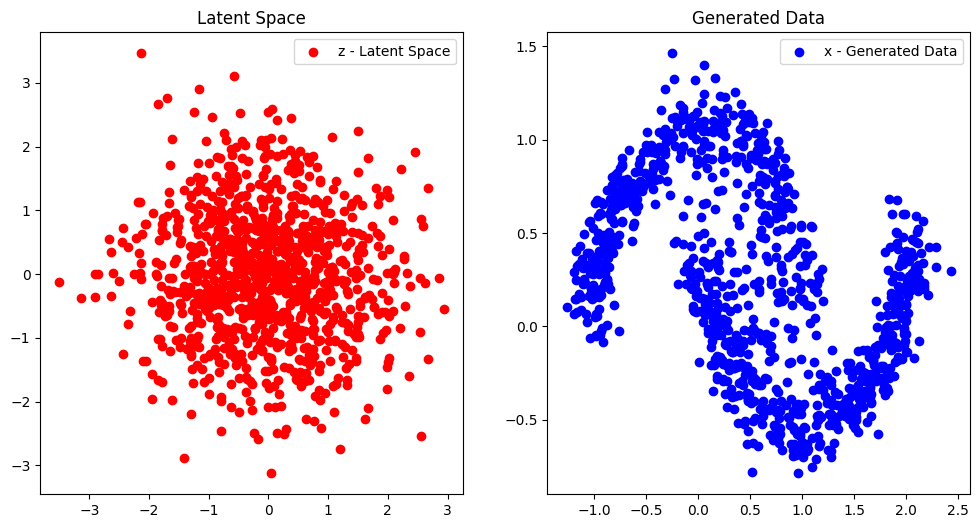

MMD Value: 0.055289093405008316


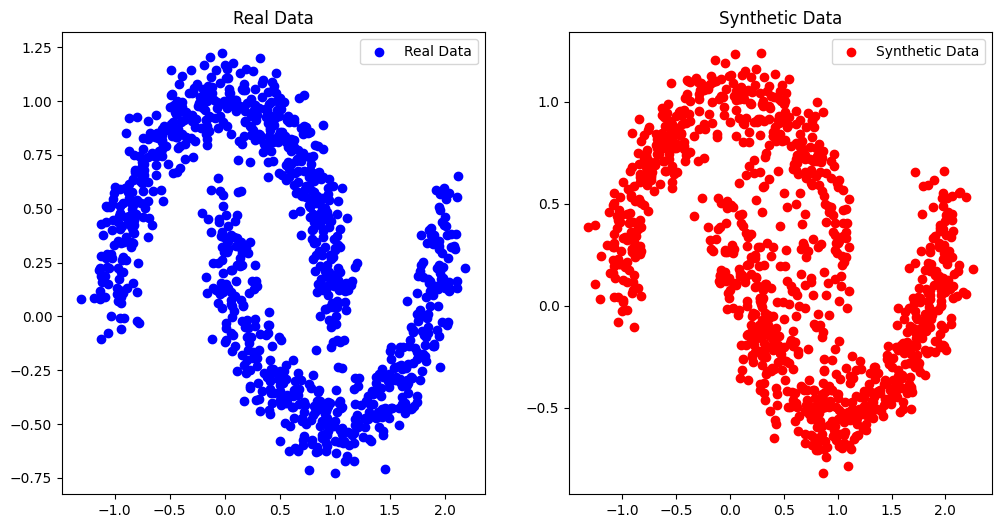

Train Epoch: 41 [0/1000 (0%)]	Loss: -0.037587
====> Epoch: 41 Average loss: -0.0394
Train Epoch: 42 [0/1000 (0%)]	Loss: -0.038049
====> Epoch: 42 Average loss: -0.0393
Train Epoch: 43 [0/1000 (0%)]	Loss: -0.037073
====> Epoch: 43 Average loss: -0.0392
Train Epoch: 44 [0/1000 (0%)]	Loss: -0.038937
====> Epoch: 44 Average loss: -0.0392
Train Epoch: 45 [0/1000 (0%)]	Loss: -0.038638
====> Epoch: 45 Average loss: -0.0393
Train Epoch: 46 [0/1000 (0%)]	Loss: -0.038121
====> Epoch: 46 Average loss: -0.0394
Train Epoch: 47 [0/1000 (0%)]	Loss: -0.039164
====> Epoch: 47 Average loss: -0.0395
Train Epoch: 48 [0/1000 (0%)]	Loss: -0.038027
====> Epoch: 48 Average loss: -0.0395
Train Epoch: 49 [0/1000 (0%)]	Loss: -0.038324
====> Epoch: 49 Average loss: -0.0394
Train Epoch: 50 [0/1000 (0%)]	Loss: -0.038503
====> Epoch: 50 Average loss: -0.0394
====> Test set loss: -0.0386


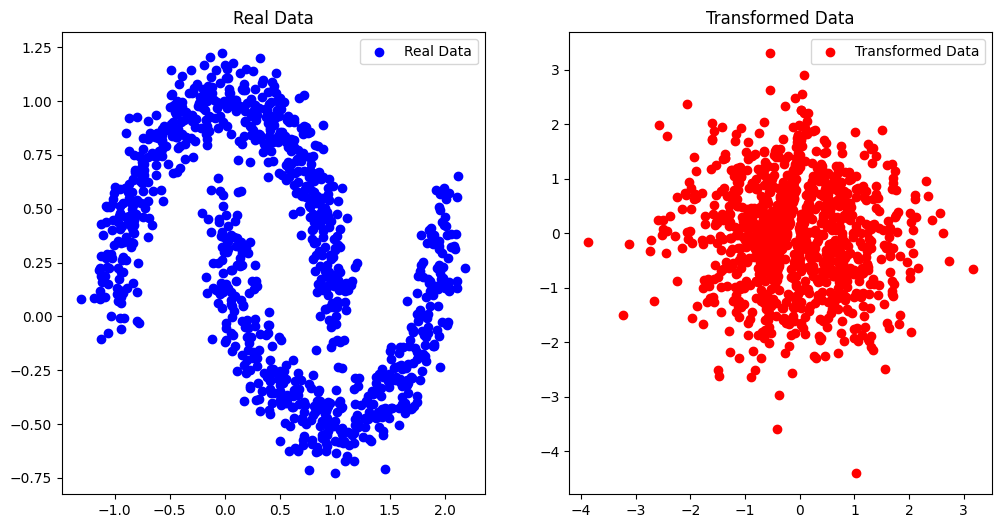

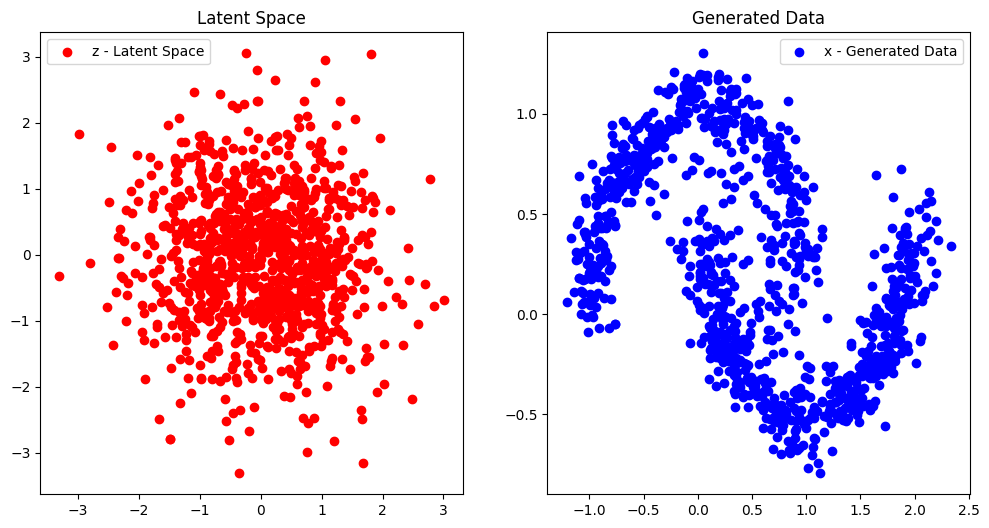

MMD Value: 0.04437587410211563


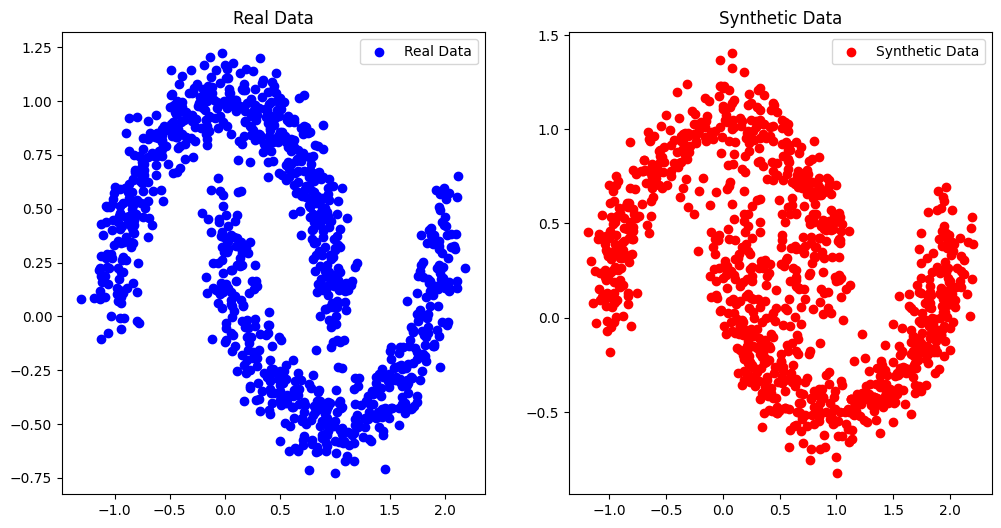

Train Epoch: 51 [0/1000 (0%)]	Loss: -0.038417
====> Epoch: 51 Average loss: -0.0395
Train Epoch: 52 [0/1000 (0%)]	Loss: -0.038750
====> Epoch: 52 Average loss: -0.0393
Train Epoch: 53 [0/1000 (0%)]	Loss: -0.037859
====> Epoch: 53 Average loss: -0.0393
Train Epoch: 54 [0/1000 (0%)]	Loss: -0.038238
====> Epoch: 54 Average loss: -0.0393
Train Epoch: 55 [0/1000 (0%)]	Loss: -0.039118
====> Epoch: 55 Average loss: -0.0392
Train Epoch: 56 [0/1000 (0%)]	Loss: -0.038675
====> Epoch: 56 Average loss: -0.0392
Train Epoch: 57 [0/1000 (0%)]	Loss: -0.038584
====> Epoch: 57 Average loss: -0.0391
Train Epoch: 58 [0/1000 (0%)]	Loss: -0.037733
====> Epoch: 58 Average loss: -0.0393
Train Epoch: 59 [0/1000 (0%)]	Loss: -0.038099
====> Epoch: 59 Average loss: -0.0394
Train Epoch: 60 [0/1000 (0%)]	Loss: -0.038891
====> Epoch: 60 Average loss: -0.0394
====> Test set loss: -0.0387


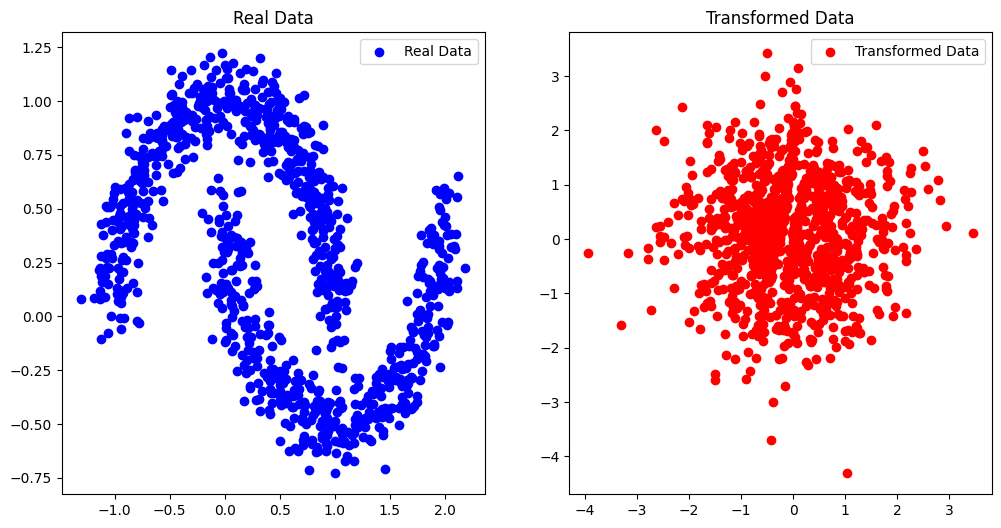

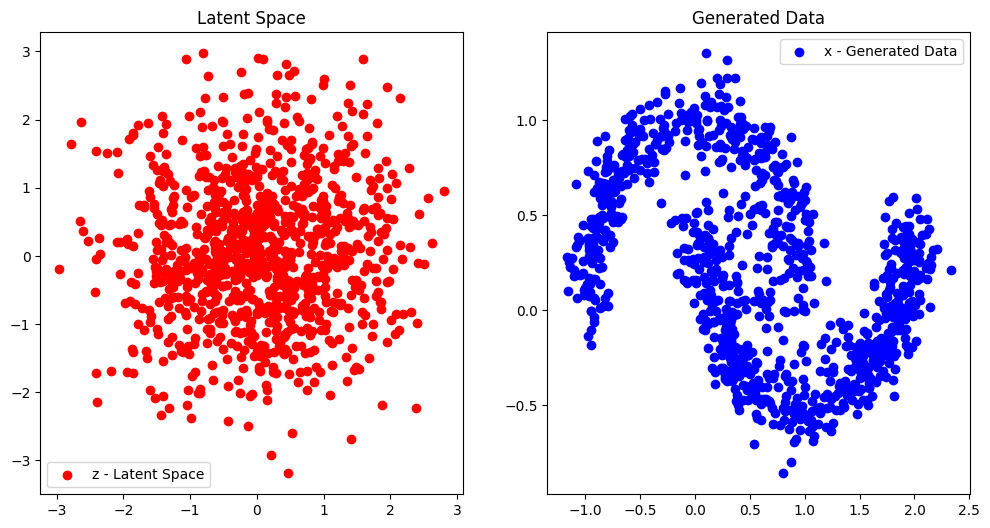

MMD Value: 0.03599894791841507


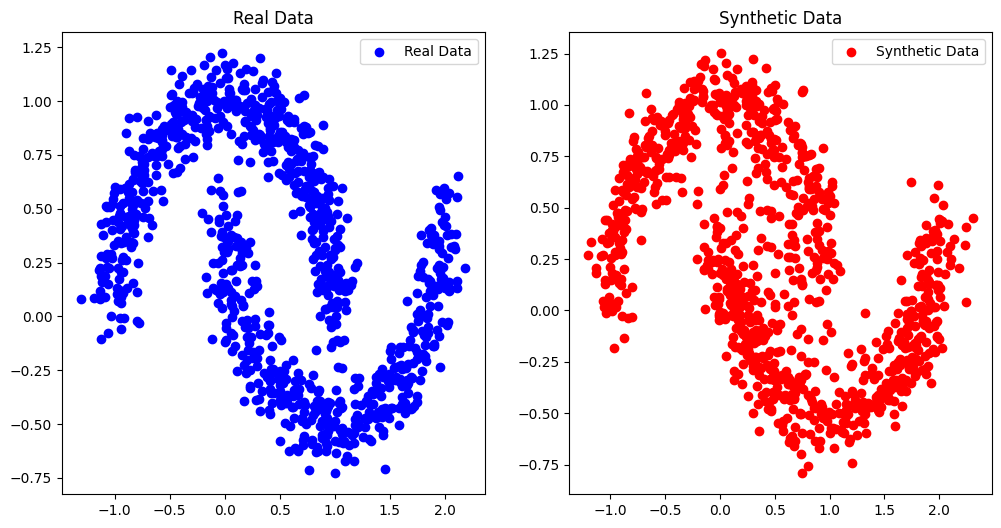

Train Epoch: 61 [0/1000 (0%)]	Loss: -0.038086
====> Epoch: 61 Average loss: -0.0395
Train Epoch: 62 [0/1000 (0%)]	Loss: -0.038801
====> Epoch: 62 Average loss: -0.0395
Train Epoch: 63 [0/1000 (0%)]	Loss: -0.038788
====> Epoch: 63 Average loss: -0.0396
Train Epoch: 64 [0/1000 (0%)]	Loss: -0.038349
====> Epoch: 64 Average loss: -0.0395
Train Epoch: 65 [0/1000 (0%)]	Loss: -0.038335
====> Epoch: 65 Average loss: -0.0395
Train Epoch: 66 [0/1000 (0%)]	Loss: -0.037887
====> Epoch: 66 Average loss: -0.0394
Train Epoch: 67 [0/1000 (0%)]	Loss: -0.038430
====> Epoch: 67 Average loss: -0.0394
Train Epoch: 68 [0/1000 (0%)]	Loss: -0.038659
====> Epoch: 68 Average loss: -0.0394
Train Epoch: 69 [0/1000 (0%)]	Loss: -0.039273
====> Epoch: 69 Average loss: -0.0394
Train Epoch: 70 [0/1000 (0%)]	Loss: -0.038139
====> Epoch: 70 Average loss: -0.0392
====> Test set loss: -0.0386


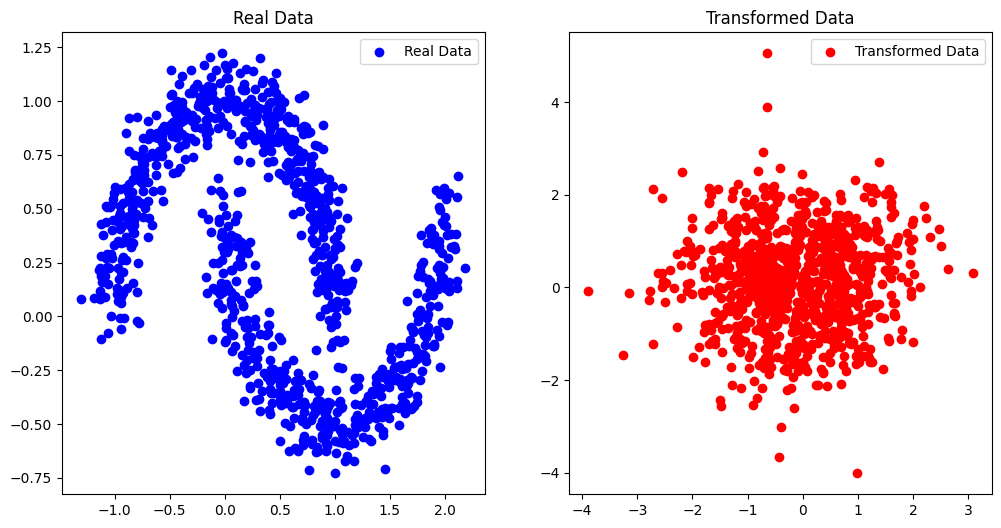

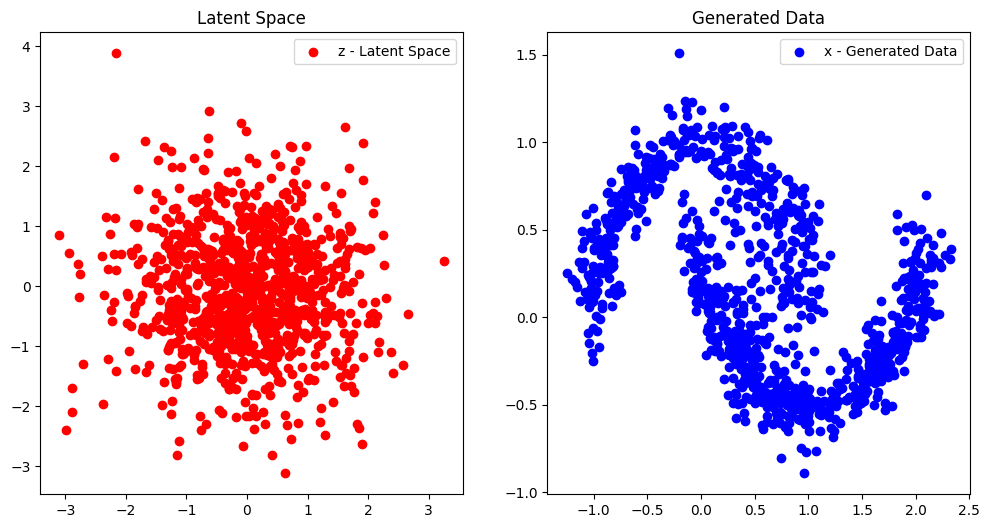

MMD Value: 0.08051533997058868


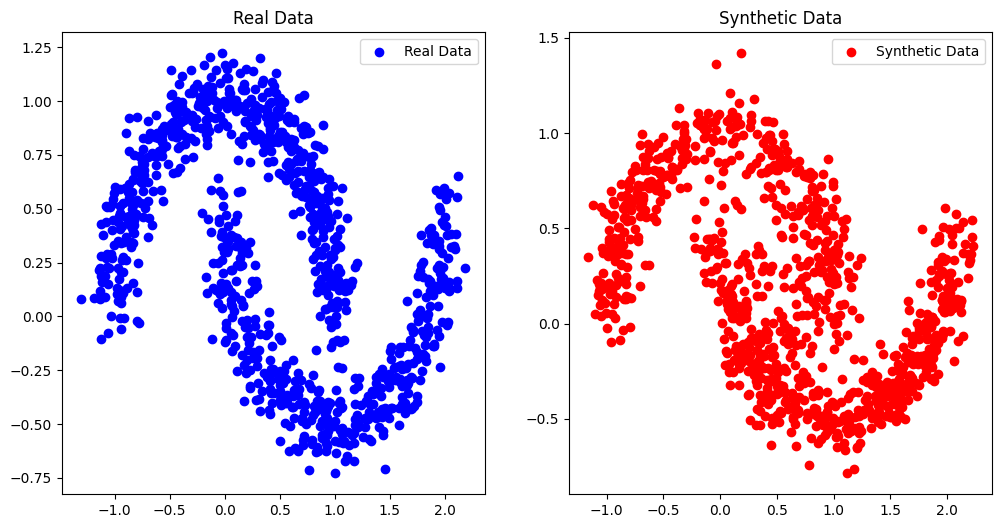

Train Epoch: 71 [0/1000 (0%)]	Loss: -0.038432
====> Epoch: 71 Average loss: -0.0394
Train Epoch: 72 [0/1000 (0%)]	Loss: -0.037531
====> Epoch: 72 Average loss: -0.0394
Train Epoch: 73 [0/1000 (0%)]	Loss: -0.038538
====> Epoch: 73 Average loss: -0.0394
Train Epoch: 74 [0/1000 (0%)]	Loss: -0.039517
====> Epoch: 74 Average loss: -0.0396
Train Epoch: 75 [0/1000 (0%)]	Loss: -0.038457
====> Epoch: 75 Average loss: -0.0395
Train Epoch: 76 [0/1000 (0%)]	Loss: -0.038607
====> Epoch: 76 Average loss: -0.0392
Train Epoch: 77 [0/1000 (0%)]	Loss: -0.038077
====> Epoch: 77 Average loss: -0.0389
Train Epoch: 78 [0/1000 (0%)]	Loss: -0.037267
====> Epoch: 78 Average loss: -0.0391
Train Epoch: 79 [0/1000 (0%)]	Loss: -0.038750
====> Epoch: 79 Average loss: -0.0394
Train Epoch: 80 [0/1000 (0%)]	Loss: -0.038608
====> Epoch: 80 Average loss: -0.0393
====> Test set loss: -0.0383


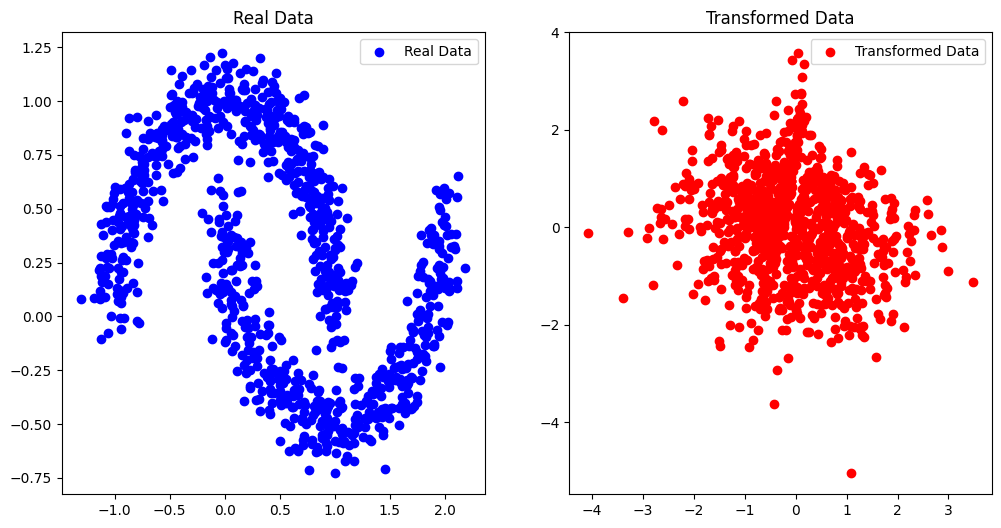

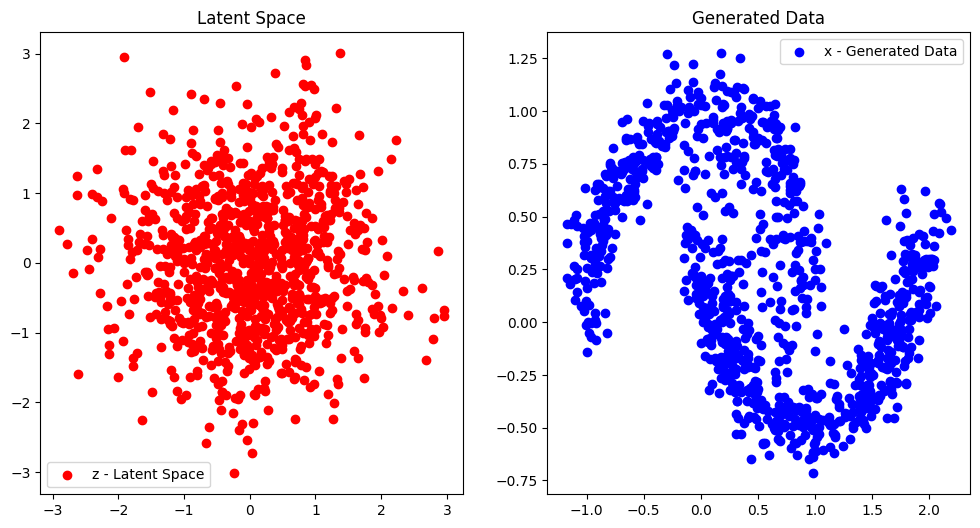

MMD Value: 0.03887896239757538


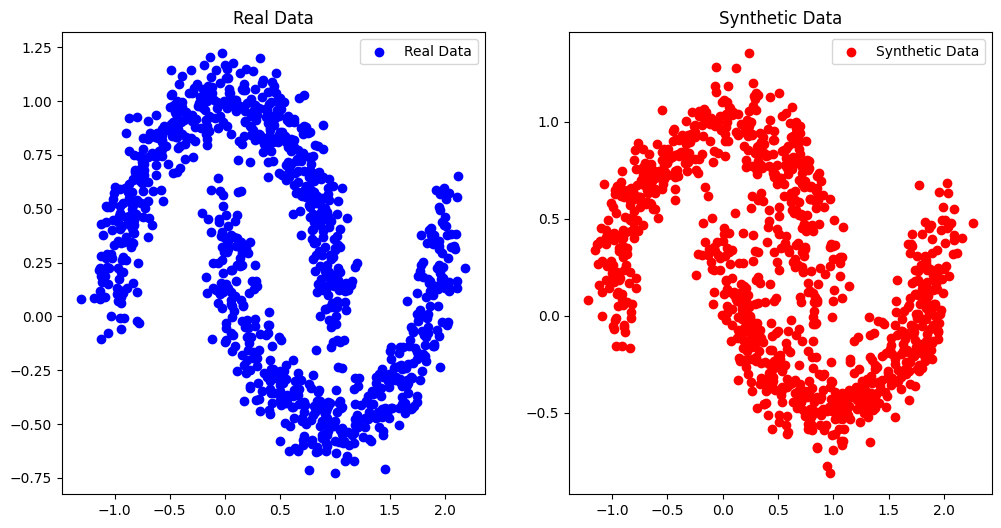

Train Epoch: 81 [0/1000 (0%)]	Loss: -0.038812
====> Epoch: 81 Average loss: -0.0393
Train Epoch: 82 [0/1000 (0%)]	Loss: -0.038700
====> Epoch: 82 Average loss: -0.0394
Train Epoch: 83 [0/1000 (0%)]	Loss: -0.039767
====> Epoch: 83 Average loss: -0.0395
Train Epoch: 84 [0/1000 (0%)]	Loss: -0.038096
====> Epoch: 84 Average loss: -0.0395
Train Epoch: 85 [0/1000 (0%)]	Loss: -0.038836
====> Epoch: 85 Average loss: -0.0394
Train Epoch: 86 [0/1000 (0%)]	Loss: -0.038413
====> Epoch: 86 Average loss: -0.0395
Train Epoch: 87 [0/1000 (0%)]	Loss: -0.038716
====> Epoch: 87 Average loss: -0.0395
Train Epoch: 88 [0/1000 (0%)]	Loss: -0.038165
====> Epoch: 88 Average loss: -0.0395
Train Epoch: 89 [0/1000 (0%)]	Loss: -0.038446
====> Epoch: 89 Average loss: -0.0395
Train Epoch: 90 [0/1000 (0%)]	Loss: -0.038530
====> Epoch: 90 Average loss: -0.0395
====> Test set loss: -0.0386


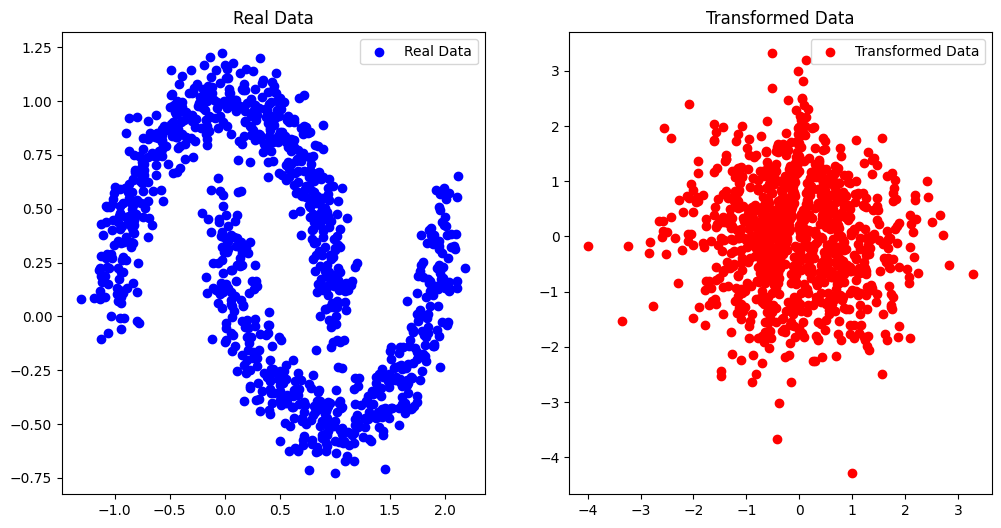

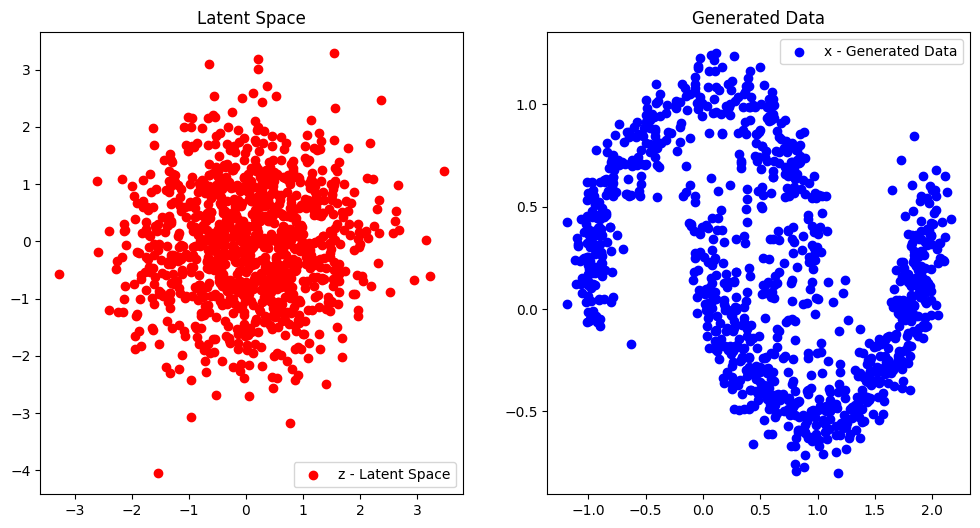

MMD Value: 0.049759190529584885


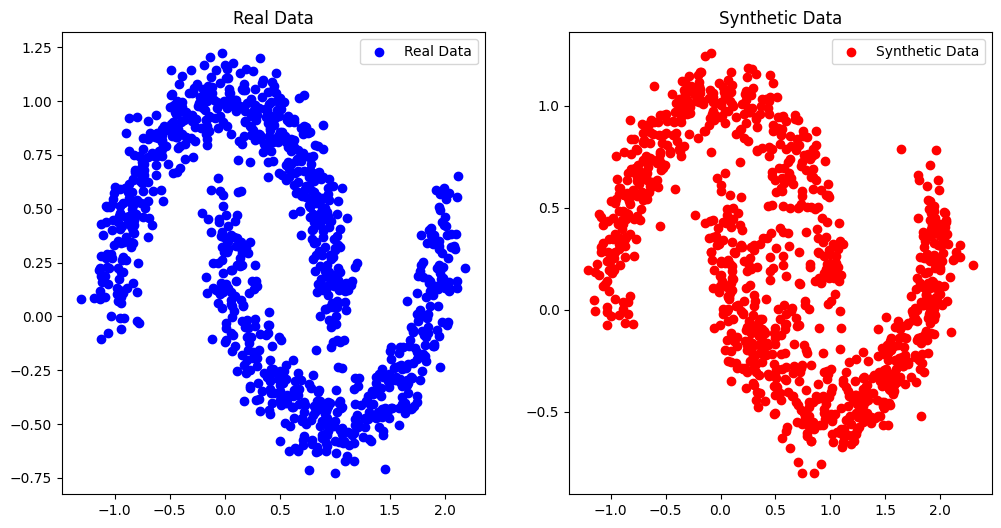

Train Epoch: 91 [0/1000 (0%)]	Loss: -0.038196
====> Epoch: 91 Average loss: -0.0395
Train Epoch: 92 [0/1000 (0%)]	Loss: -0.038226
====> Epoch: 92 Average loss: -0.0393
Train Epoch: 93 [0/1000 (0%)]	Loss: -0.038614
====> Epoch: 93 Average loss: -0.0394
Train Epoch: 94 [0/1000 (0%)]	Loss: -0.038170
====> Epoch: 94 Average loss: -0.0395
Train Epoch: 95 [0/1000 (0%)]	Loss: -0.039086
====> Epoch: 95 Average loss: -0.0395
Train Epoch: 96 [0/1000 (0%)]	Loss: -0.038446
====> Epoch: 96 Average loss: -0.0395
Train Epoch: 97 [0/1000 (0%)]	Loss: -0.039488
====> Epoch: 97 Average loss: -0.0396
Train Epoch: 98 [0/1000 (0%)]	Loss: -0.039384
====> Epoch: 98 Average loss: -0.0395
Train Epoch: 99 [0/1000 (0%)]	Loss: -0.038007
====> Epoch: 99 Average loss: -0.0394
Train Epoch: 100 [0/1000 (0%)]	Loss: -0.038499
====> Epoch: 100 Average loss: -0.0394
====> Test set loss: -0.0387


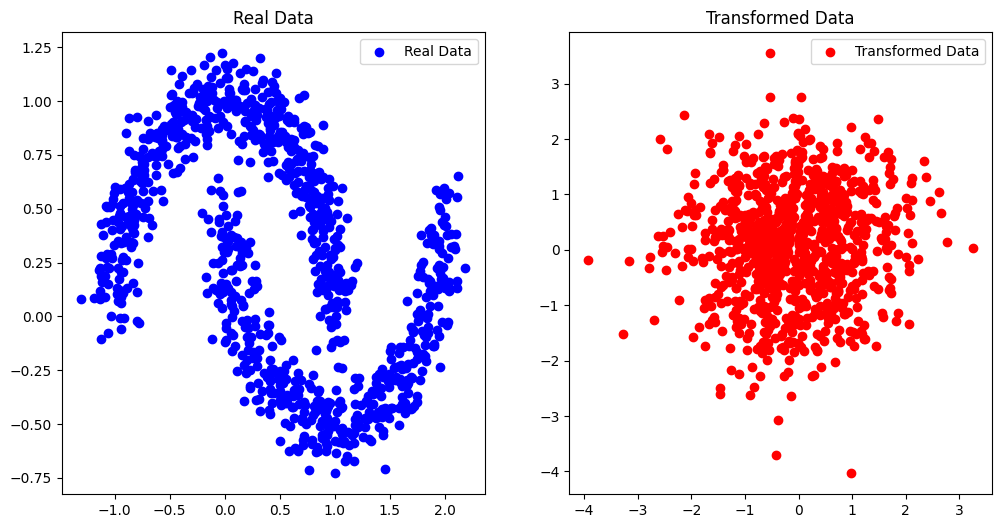

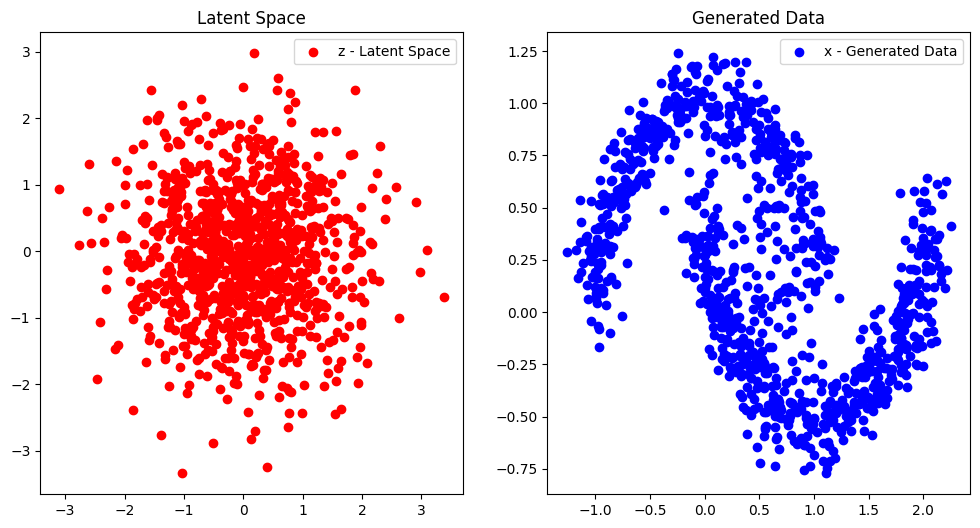

MMD Value: 0.06195402145385742


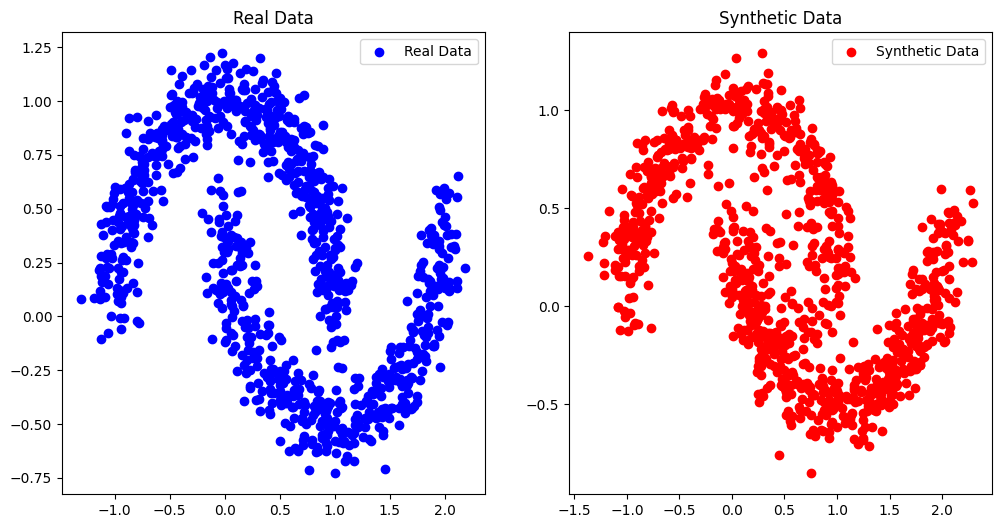

In [ ]:
if __name__ == '__main__':
    for epoch in range(1, EPOCHS + 1):
        train(epoch)

        if epoch % 10 == 0:  # Only call test, sample, and report_mmd every 10 epochs
            test(epoch)
            sample(epoch)
            report_mmd()



### comments:
1.Based on the output of your training sessions, it appears that your RealNVP model is performing well in terms of invertibility. The invertibility errors are very small (on the order of 1 0 − 14 10 −14 ), which suggests that the model's reverse pass (decoding) is effectively the exact inverse of the forward pass (encoding), up to very tiny numerical errors. This is a crucial property for the RealNVP model and indicates success in this aspect.

Additionally, the mean losses are relatively stable across different configurations. This stability is a good sign, but you may want to consider additional performance metrics or validation techniques to thoroughly assess the model's learning and generalization capabilities.

2.The model has learned well with synthetic_data and try to project the 2 moon cresent structure as similar to test_data with the MMD value 0.061954(close to 0)

Repeat the experiments (at good hyperparameter settings) with a Gaussian mixture whose centers are on the corners of a regular hexagon, like in the
gure below. The standard deviations shall be 1/10 of the radius of the hexagon. Again comment on your observations  is the GMM more di
cult than the two moons?

In [ ]:
def generate_hexagon_gmm_data(n_samples, hexagon_radius, std_dev):
    angles = np.linspace(0, 2 * np.pi, 6, endpoint=False)
    centers = np.stack((np.cos(angles), np.sin(angles)), axis=-1) * hexagon_radius
    data = np.vstack([np.random.normal(center, std_dev, size=(n_samples // 6, 2)) for center in centers])
    return data

# Hyperparameters
n_samples = 2000
hexagon_radius = 10  # Example radius
std_dev = hexagon_radius * 0.1  # Standard deviation is 1/10th of the radius

# Generate GMM data
gmm_data = generate_hexagon_gmm_data(n_samples, hexagon_radius, std_dev)
scaler = StandardScaler()
gmm_data_scaled = scaler.fit_transform(gmm_data)

# Split the data into training and testing
X_train, X_test = train_test_split(gmm_data_scaled, test_size=0.5, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Define the model, optimizer, and train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RealNVP(input_dim=2, output_dim=2, hid_dim=256, mask=torch.tensor([0, 1], dtype=torch.float32), n_layers=5)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training and testing functions need to be defined here
def train(epoch, model, X_train, optimizer):
    # Set the model to training mode
    model.train()

    # Initialize variables to store training loss, etc.
    train_loss = 0

    # Convert the dataset to a DataLoader if not already done
    # Assuming X_train is a torch.Tensor
    train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)

    # Training loop
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass through the model
        z, log_det_j_sum = model(data)
        loss = -(prior_z.log_prob(z) + log_det_j_sum).mean()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the training loss
        train_loss += loss.item()

    # Print the average loss for the epoch
    print(f'Epoch: {epoch}, Average Loss: {train_loss / len(train_loader)}')


# Training loop
for epoch in range(1, num_epochs + 1):
    train(epoch, model, X_train, optimizer)
    if epoch % 10 == 0:  # Optionally test every 10 epochs
        test(epoch, model, X_test)

# Assume train and test functions are already defined and handle RealNVP model appropriately

# Sample from the trained model and visualize
model.eval()
with torch.no_grad():
    # Generate samples
    z_samples = torch.randn(1000, 2).to(device)
    generated_samples = model.backward(z_samples).cpu().numpy()

    # Reverse transform the generated samples to the original scale
    generated_samples = scaler.inverse_transform(generated_samples)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.scatter(gmm_data[:, 0], gmm_data[:, 1], c='green', label='Original GMM Data')
    plt.scatter(generated_samples[:, 0], generated_samples[:, 1], c='red', alpha=0.6, label='Generated Data')
    plt.legend()
    plt.title('Original GMM Data vs Generated Data')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

TypeError: ignored

<div style="color: green; font-weight:
bold"> Comments:
1.In the realNVP implementation, code introduces a more dynamic approach to constructing layers with the use of a mask and alternating the flow in each layer. This could potentially offer more flexibility and control over the model.<br>
2.Refactoring the code is required <br>
3.Gaussian mixture whose centers are on the corners of a regular hexagon,is not properly implemented.<br> 
4.The code integrates visualization directly within the training and testing loops. This allows for immediate feedback on the model's performance and is useful for debugging and optimizing.<br>
5.Has a streamlined implementation for MMD computation, which is integrated into the model evaluation process. This is efficient for regularly assessing the model's performance.<br>
</div>

** 2
Two moons with a conditional invertible neural network

The function sklearn.datasets.make_moons also returns a label for the moon where each data point belongs to, and your function to generate the GMM on the hexagon can easily be extended to do this as well. We can use this information to train a conditional RealNVP for the conditional distribution p(x | y) with y the label. Here, the nested networks receive a one-hot encoding of the label as an additional input for both the forward and reverse passes through the RealNVP. Extend the implementation from task 1 accordingly. The constructor needs a new argument condition_size, and the encoder and decoder functions must now accept a condition of appropriate size.

Make sure that the generalized design works in vectorized mode. Especially, the extended function RealNVP.sample(self, num_samples, conditions) should generate num_sample points for every row of

condition.

Now, train the conditional INN with the labels from the two moons and the GMM. In addition, train for the GMM with only two labels, such that two peaks get label 0, and the other four are label 1 (you can imagine that two peaks are red, and the others are green). Evaluate your networks first in conditional mode p(x | y), i.e. by evaluating for one label at a time, and compare with test data from the true conditional distributions.

Then, merge synthetic data from all labels and compare the marginal distributions p(x). Is the quality of the conditional INN better or worse than the plain INN from task 1? **

#Task 2

The function sklearn.datasets.make_moons also returns a label for the moon where each data point
belongs to, and your function to generate the GMM on the hexagon can easily be extended to
do this as well. We can use this information to train a conditional RealNVP for the conditional
distribution p(x | y) with y the label. Here, the nested networks receive a one-hot encoding of the
label as an additional input for both the forward and reverse passes through the RealNVP. Extend
the implementation from task 1 accordingly. The constructor needs a new argument condition_size,
and the encoder and decoder functions must now accept a condition of appropriate size.




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

import numpy as np
from scipy.stats import ortho_group



In [ ]:
def permutation_matrix(dim):
    matrix = np.eye(dim)
    np.random.shuffle(matrix)
    return torch.tensor(matrix, dtype=torch.float32)

class RealNVP_condition(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP_condition, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(mask))])

    def f(self, x, condition):

        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in (range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](torch.cat([condition,z_], dim=1)) * (1-self.mask[i])
            t = self.t[i](torch.cat([condition,z_], dim=1)) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def g(self, z, condition):
        x = z
        for i in reversed(range(len(self.t))):
            x_ = x*self.mask[i]
            s = self.s[i](torch.cat([condition,x_], dim=1))*(1 - self.mask[i])
            t = self.t[i](torch.cat([condition,x_], dim=1))*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x


    def log_prob(self,x, condition):
        z, logp = self.f(x, condition)
        return self.prior.log_prob(z) + logp

    def sample(self, batchSize, condition):
        z = self.prior.sample((batchSize, ))

        x = self.g(z, condition)
        return x

In [ ]:
# for 2 moons
nets = lambda: nn.Sequential(nn.Linear(4, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(4, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))

masks = torch.from_numpy(np.array([[1, 0]] * 6).astype(np.float32))
for i in range(len(masks)):
  masks[i]=torch.matmul(permutation_matrix(2),masks[i])
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP_condition(nets, nett, masks, prior)

print(masks)

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])


Comments:

We built this conditional model with 6 layers, and each scalar nn and translation nn have 3 hidden layers with size 256. And as the result shown above, we used a random permutation matrix to permutate every mask.

In [ ]:
import torch
from sklearn.datasets import make_moons
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt
# Create training set and testing
X, l = make_moons(n_samples=1000, noise=0.05, random_state=42)
X = torch.FloatTensor(X)
l = torch.FloatTensor(l)

# convert it to tensor
dataset = TensorDataset(X, l)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)



optimizer = optim.Adam(flow.parameters(), lr=0.001)

#Train
num_epochs = 50
loss_list=[]

for epoch in range(num_epochs):
    for data in data_loader:
        inputs, labels = data
        labels=labels.long()

        conditions = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=2)


        loss = -flow.log_prob(inputs.float(),conditions.float()).mean()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    loss_list.append(loss.item())

<ipython-input-4-f22349ab7496>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conditions = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=2)


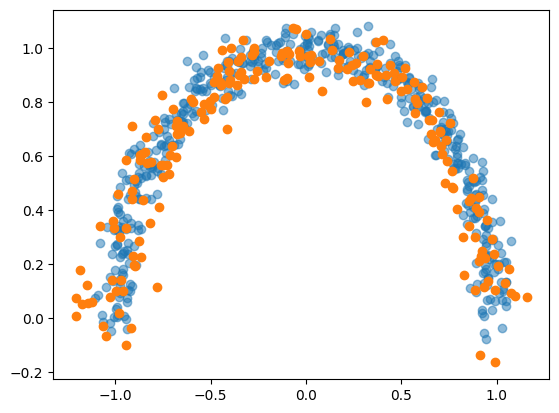

In [ ]:
#generating data for label0 p(x|y=0)

n_samples=200
condition0=torch.zeros(n_samples, 2)
condition0[:, 0] = 1.0
x = flow.sample(n_samples,condition0).detach().numpy()
data_moon_0 = X[l == 0]
plt.scatter(data_moon_0[:,0],data_moon_0[:,1],alpha=0.5,label='original data')
plt.scatter(x[:, 0], x[:,  1], label='generated data')


Comments:

Here we show the generated data with label 0,  i.e. $ \hat{p}(x|y=0)$.This model can fit the data well, but there is some divergence at both ends.




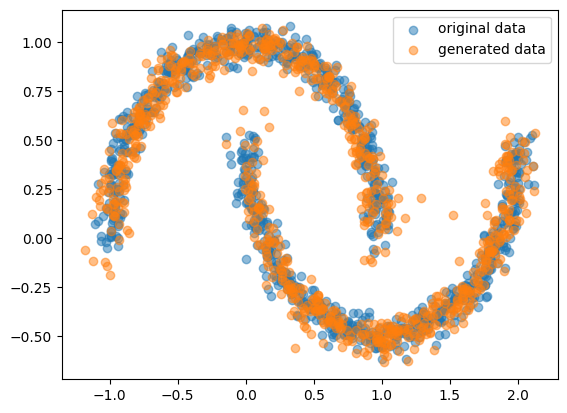

In [ ]:
#generating data for marginal distribution p(x)
n_samples=400
condition0=torch.zeros(n_samples, 2)
condition1=torch.zeros(n_samples, 2)
condition0[:, 0] = 1.0
condition1[:, 1] = 1.0
x = flow.sample(n_samples,condition0).detach().numpy()
y=flow.sample(n_samples,condition1).detach().numpy()
marginal=np.vstack((x,y))
plt.scatter(X[:,0],X[:,1],alpha=0.5,label='original data')
plt.scatter(marginal[:, 0], marginal[:,  1],alpha=0.5, label='generated data')
plt.legend()
plt.show()

Comments:

We generated sample from the marginal distribution p(x). Compared with the model in task i, this model works better.

In [ ]:
def generate_gmm_data_with_labels(n_samples, hexagon_radius, std_dev_factor):
    angles = np.linspace(0, 2 * np.pi, 6, endpoint=False)
    centers = np.stack((np.cos(angles), np.sin(angles)), axis=-1) * hexagon_radius
    std_dev = hexagon_radius * std_dev_factor
    data = []
    labels = []
    samples_per_cluster = n_samples // 6
    for i, center in enumerate(centers):
        cluster_data = np.random.normal(center, std_dev, size=(samples_per_cluster, 2))
        data.append(cluster_data)
        labels.append(np.full(samples_per_cluster, i))  # Assign label to each sample in the cluster
    return np.concatenate(data), np.concatenate(labels)

# Hyperparameters
n_samples = 2000
hexagon_radius = 10  # Example radius
std_dev_factor = 1/10  # Standard deviation as a fraction of the radius

# Generate the GMM dataset with labels
data_hexagon, labels_hexagon = generate_gmm_data_with_labels(n_samples, hexagon_radius, std_dev_factor)



In [ ]:
#model
n_labels=6
dim=2
nets = lambda: nn.Sequential(nn.Linear(dim+n_labels, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(dim+n_labels, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim))
masks = torch.from_numpy(np.array([[1, 0]] * 6).astype(np.float32))
for i in range(len(masks)):
  masks[i]=torch.matmul(permutation_matrix(2),masks[i])
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP_condition(nets, nett, masks, prior)


In [ ]:

# Create training set and testing
X=data_hexagon
X = torch.FloatTensor(X)
l = torch.FloatTensor(labels_hexagon)

# convert it to tensor
dataset = TensorDataset(X, l)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)


#train
optimizer = optim.Adam(flow.parameters(), lr=0.001)


num_epochs = 50
loss_list=[]

for epoch in range(num_epochs):
    for data in data_loader:
        inputs, labels = data
        labels=labels.long()

        conditions = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=n_labels)


        loss = -flow.log_prob(inputs.float(),conditions.float()).mean()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    loss_list.append(loss.item())

<ipython-input-11-74dc2e6c2986>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conditions = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=n_labels)


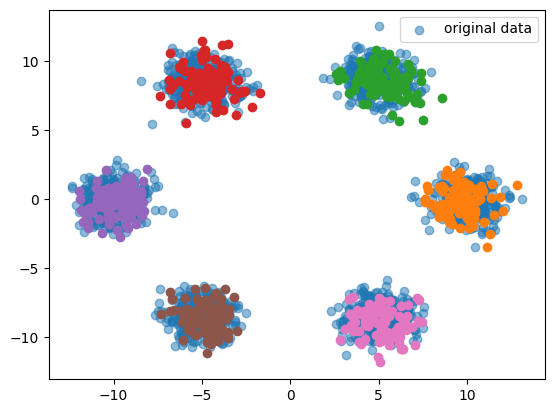

In [ ]:
#generating data
n_samples=100
condition = torch.eye(n_labels, dtype=torch.float32)
condition=torch.tile(condition.unsqueeze(0), (n_samples, 1, 1))
plt.scatter(data_hexagon[:,0],data_hexagon[:,1],alpha=0.5,label='original data')

for i in range(n_labels):
  x=flow.sample(n_samples,condition[:,i,:]).detach().numpy()
  plt.scatter(x[:, 0], x[:,  1])
plt.legend()
plt.show()

Comment:

This model can fit every coditional distribution well and find the right mean and variance. Since Y follows a uniform distribution, the generated data under all labels together is exactly the marginal distribution $ \hat{p}(x)$. And it works better than the unconditional model.


train for the GMM with only two labels, such that two peaks get label 0, and the other four are
label 1 (you can imagine that two peaks are red, and the others are green). Evaluate your networks
First in conditional mode p(x | y), i.e. by evaluating for one label at a time, and compare with test
data from the true conditional distributions.

Then, merge synthetic data from all labels and compare the marginal distributions p(x). Is the
quality of the conditional INN better or worse than the plain INN from task 1?


In [ ]:
#model with 2 conditions(labels)
n_labels=2
dim=2
nets = lambda: nn.Sequential(nn.Linear(dim+n_labels, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(dim+n_labels, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim))
masks = torch.from_numpy(np.array([[1, 0]] * 6).astype(np.float32))
for i in range(len(masks)):
  masks[i]=torch.matmul(permutation_matrix(dim),masks[i])
prior = distributions.MultivariateNormal(torch.zeros(dim), torch.eye(dim))
flow = RealNVP_condition(nets, nett, masks, prior)


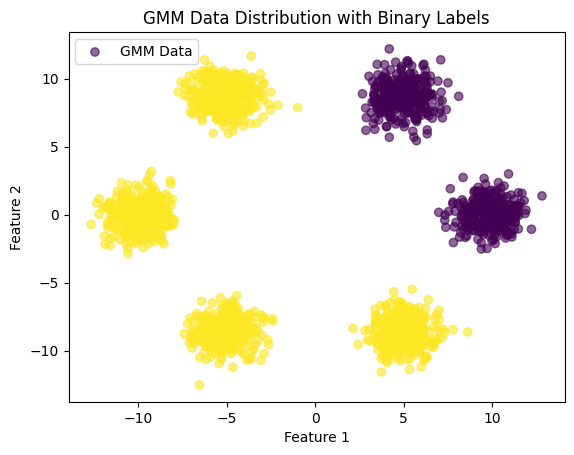

In [ ]:
def generate_gmm_data_with_2_labels(n_samples, hexagon_radius, std_dev_factor):
    angles = np.linspace(0, 2 * np.pi, 6, endpoint=False)
    centers = np.stack((np.cos(angles), np.sin(angles)), axis=-1) * hexagon_radius
    std_dev = hexagon_radius * std_dev_factor
    data = []
    labels = []
    samples_per_cluster = n_samples // 6
    for i, center in enumerate(centers):
        cluster_data = np.random.normal(center, std_dev, size=(samples_per_cluster, 2))
        data.append(cluster_data)
        if i < 2:
            labels.append(np.zeros(samples_per_cluster))  # Assign label 0 to the first 2 clusters
        else:
            labels.append(np.ones(samples_per_cluster))   # Assign label 1 to the last 4 clusters
    return np.concatenate(data), np.concatenate(labels)

n_samples = 2000
hexagon_radius = 10
std_dev_factor = 1/10

# Generate the GMM dataset with labels
data_2, labels_2 = generate_gmm_data_with_2_labels(n_samples, hexagon_radius, std_dev_factor)


plt.scatter(data_2[:, 0], data_2[:, 1], c=labels_2, cmap='viridis', alpha=0.6, label='GMM Data')
plt.title('GMM Data Distribution with Binary Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()



In [ ]:
#train
X=data_2
X = torch.FloatTensor(X)
l = torch.FloatTensor(labels_2)

# convert it to tensor
dataset = TensorDataset(X, l)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)



optimizer = optim.Adam(flow.parameters(), lr=0.001)


num_epochs = 100
loss_list=[]

for epoch in range(num_epochs):
    for data in data_loader:
        inputs, labels = data
        labels=labels.long()

        conditions = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=n_labels)

        loss = -flow.log_prob(inputs.float(),conditions.float()).mean()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    loss_list.append(loss.item())

<ipython-input-15-12ed96ffb96b>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conditions = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=n_labels)


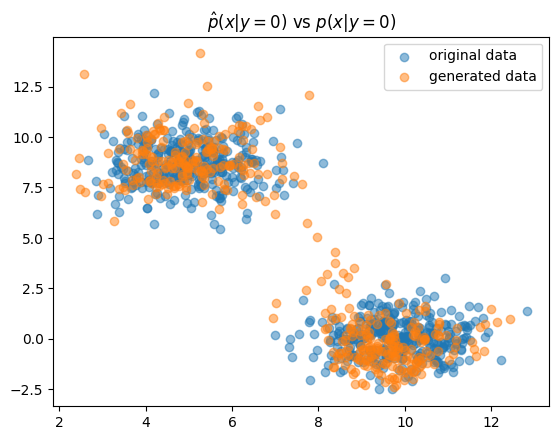

In [ ]:
#generating data for label0 p(x|y=0)
n_samples=400
condition = torch.eye(n_labels, dtype=torch.float32)
condition=torch.tile(condition.unsqueeze(0), (n_samples, 1, 1))
x=flow.sample(n_samples,condition[:,0,:]).detach().numpy()
data_label_0 = data_2[labels_2 == 0]
plt.scatter(data_label_0[:,0],data_label_0[:,1],alpha=0.5,label='original data')
plt.scatter(x[:, 0], x[:,  1],alpha=0.5,label='generated data')
plt.legend()
plt.title('$ \hat{p}(x|y=0)$ vs $p(x|y=0)$')
plt.show()

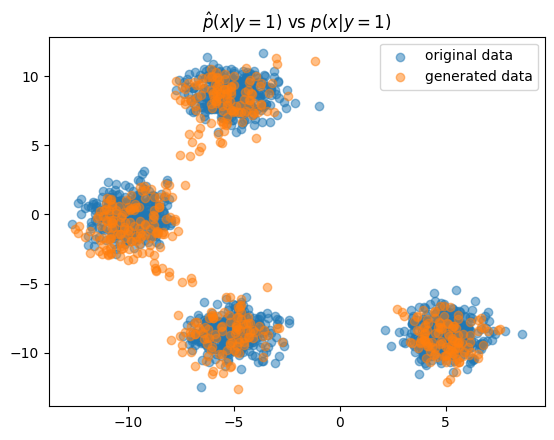

In [ ]:
#generating data for label1 p(x|y=1)
n_samples=500
condition = torch.eye(n_labels, dtype=torch.float32)
condition=torch.tile(condition.unsqueeze(0), (n_samples, 1, 1))
x=flow.sample(n_samples,condition[:,1,:]).detach().numpy()
data_label_1 = data_2[labels_2 == 1]
plt.scatter(data_label_1[:,0],data_label_1[:,1],alpha=0.5,label='original data')
plt.scatter(x[:, 0], x[:,  1],alpha=0.5,label='generated data')
plt.legend()
plt.title('$ \hat{p}(x|y=1)$ vs $p(x|y=1)$')
plt.show()

Comments:

We can see the conditionL distributions above, which are a little different from the true different distributions.Though this model can find the centers (means) of every cluster, it also generated some data in gaps. Then we generate the marginal distribution and compare it to the former one.

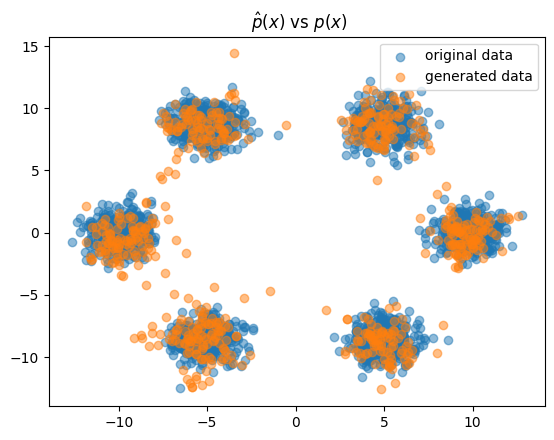

In [ ]:
#generating data for marginal distribution p(x)
n_samples=100
conditions = torch.eye(n_labels, dtype=torch.float32)
conditions=torch.tile(conditions.unsqueeze(0), (n_samples*4, 1, 1))

x=flow.sample(n_samples*2,conditions[:n_samples*2,0,:]).detach().numpy()
y=flow.sample(n_samples*4,conditions[:n_samples*4,1,:]).detach().numpy()
marginal_hexagon=np.vstack((x,y))
plt.scatter(data_2[:,0],data_2[:,1],alpha=0.5,label='original data')
plt.scatter(marginal_hexagon[:, 0], marginal_hexagon[:,  1],alpha=0.5,label='generated data')
plt.title(" $ \hat{p}(x)$ vs $ p(x)$")
plt.legend()
plt.show()

Comments:

Accroding to the way we generated data from a GMM model with 2 labels, Y follows the distribution p(Y=0)=1/3, P(Y=1)=2/3. Then we generated $ \hat{p}(X) $.   It worked worse than the conditional INN with 6 labels, but still much better than the model from task 1. Since there are only 2 labels, this model will generate wrong data in gaps between clusters under the same label.

# Task 3

1. Repeat task 1 with the digits dataset (sklearn.datasets.load_digits()). Since these images have
size 8 × 8, the codes will be 64-dimensional. Plot various 2D projections of the code space
distribution for test data and check if the codes are indeed standard normally distributed.
Now generate data with your model. You will probably notice that the quality is not as good
as what you got from an autoencoder in exercise 02. This is likely due to the fact that the
dataset is too small to fully train a 64-dimensional code space. Recall, thet the code space in
exercise 02 was at most 8-dimensional.

<div style="color: green; font-weight:
bold">
Since there was some miscommunication, the implementation of the realNVP got messed up. Hence the code below is not consistent and cannot be compared to the provided solution.</div>

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors


In [ ]:
X_train, X_test, Y_train, Y_test = import_data(noise=0.0, n_test=0.1,  name="digits")

In [ ]:
nvp = RealNVP(64, 250, 8)
losses = nvp.train_inn(X_train, len(X_train), 30, lr=0.002)

Text(0.5, 1.0, 'Loss during training')

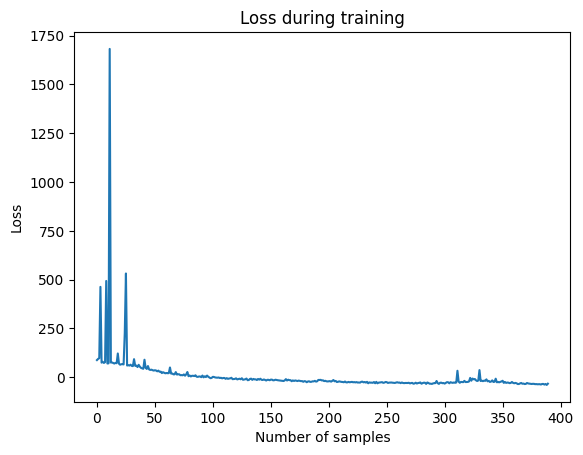

In [ ]:
plt.plot(losses)
plt.xlabel("Number of samples")
plt.ylabel("Loss")
plt.title("Loss during training")

In [ ]:
def plot_pca_projections(Z, components=[2,3]):
    normal_dist_samples = Z = torch.randn(len(X_test), 64)
    kernel_XX = se_kernel_custom(normal_dist_samples, normal_dist_samples)
    kernel_YY = se_kernel_custom(torch.tensor(code_samples), torch.tensor(code_samples))
    kernel_XY = se_kernel_custom(normal_dist_samples, torch.tensor(code_samples))

    # Compute MMD
    mmd_value = compute_mmd(kernel_XX, kernel_YY, kernel_XY)
    Z_2D = PCA().fit_transform(Z)
    fig, axs = plt.subplots(*components)
    i = 0
    fig.suptitle("2D Projection of code space using PCA")
    fig.text(0.5, 0, f"MMD Value: {mmd_value.item()}", horizontalalignment="center")
    for ax in axs.flatten():
        im = ax.hist2d(Z_2D[i], Z_2D[i+1],bins=[50,50], density=True, cmap='plasma')
        ax.set(xlabel=f"PC{i}", ylabel=f"PC{i+1}")
        #ax.set(xlim=(-1, 1), ylim=(-1, 1))
        ax.legend()
        i += 1

    fig.tight_layout()
    fig.subplots_adjust(right=1)
    fig.colorbar(im[3], ax=axs.ravel().tolist(), shrink=0.95)

Using the principal component analysis, one can observe, that the resulting distribution is roughly standard normal. It seems to be centered around 0 and most of the projected points are within a radius of 1. However there is also a fair amount of points outside of this radius. The MMD indicates, that the distribution is quite similar to a normal distribution.

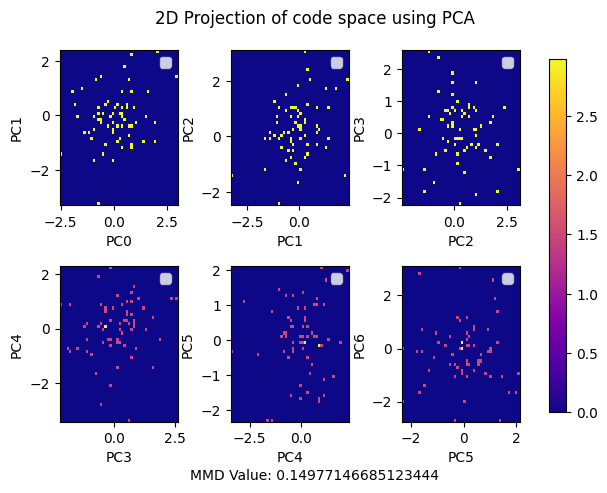

In [ ]:
code_samples, _, Qs = nvp.encode(X_test)
code_samples = np.array([c.detach().numpy() for c in code_samples])
plot_pca_projections(code_samples)

In [ ]:
def plot_reconstructions(nvp, X, samples=5):
    perm = torch.randperm(X.size(0))
    idx = perm[:samples]
    X = X[idx]
    codes, _, Qs = nvp.encode(X)
    reconstructed = nvp.decode(codes, Qs)

    fig, axs = plt.subplots(3, samples)
    i = 0
    fig.suptitle("Reconstruction of data")
    for ax in axs[0, :]:
        z = np.array([c.detach().numpy() for c in codes[i]]).reshape(8,8)
        im = ax.imshow(z, norm=colors.AsinhNorm(),cmap='plasma')
        ax.set(xlabel=f"{i} Transformed")
        i += 1

    i = 0
    for ax in axs[1, :]:
        z = np.array([c.detach().numpy() for c in reconstructed[i]]).reshape(8,8)
        im = ax.imshow(z, norm=colors.AsinhNorm(), cmap='plasma')
        ax.set(xlabel=f"{i} Recon")
        i += 1

    i = 0
    for ax in axs[2, :]:
        z = X[i].detach().numpy().reshape(8,8)
        im = ax.imshow(z, norm=colors.AsinhNorm(), cmap='plasma')
        ax.set(xlabel=f" {i} Original")
        i += 1

    fig.tight_layout()
    fig.subplots_adjust(right=1)
    fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)

Here, some samples from the dataset have been reconstructed. It is observerable, that the inversion works well. Since the dataset has been normalized, the colormap is not linear to improve contrast. The reason for normalization is, that the model does not have to learn a transform such that the data is centered around 0 with standard deviation 1.

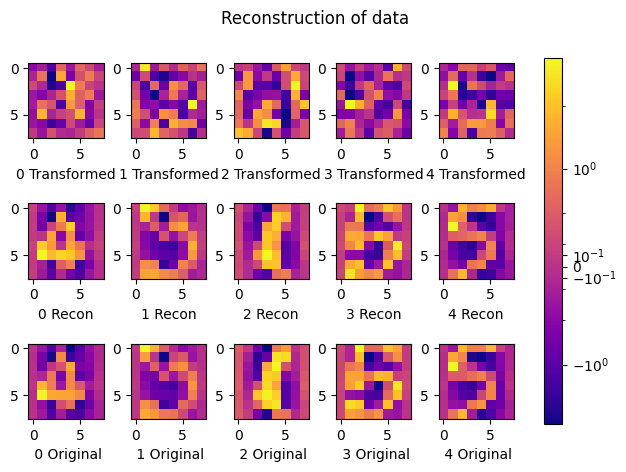

In [ ]:
plot_reconstructions(nvp, X_test)

In [ ]:
def plot_samples(nvp, samples=[3,3], k=None, mode=1):
    n_samples = samples[0] * samples[1]
    codes = nvp.sample(n_samples, mode)
    fig, axs = plt.subplots(*samples)
    i = 0
    fig.suptitle("Reconstruction of random samples")
    for ax in axs.flatten():
        z = np.array([c.detach().numpy() for c in codes[i]]).reshape(8,8)
        im = ax.imshow(z, norm=colors.AsinhNorm(),
                   cmap='plasma')
        i += 1

    fig.tight_layout()
    fig.subplots_adjust(right=1)
    fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)

As described in the assignment, the quality of the synthetic data is really not good. Some digits are still readable.

<div style="color: green; font-weight:
bold">

In the provided solution, the synthetic data looks quite different. Our solution outputs 9 times the same result, in the provided soulution the synthetic samples are different each time. However our synthetic data is more readable.  </div>

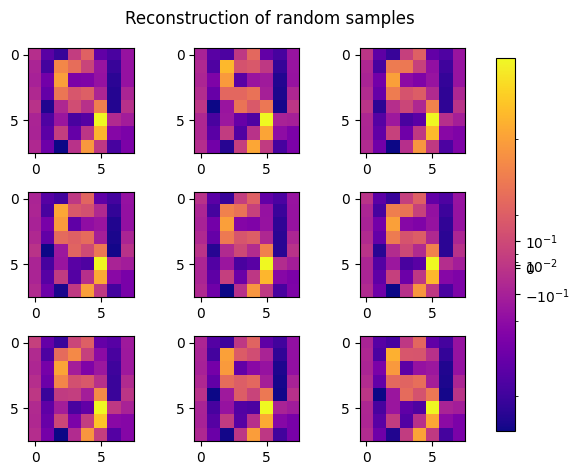

In [ ]:
plot_samples(nvp)

2. To reduce this problem, we can introduce an artificial bottleneck: In addition to the NLL
loss, we also minimize a reconstruction loss. For this to make sense in the presence of perfect
reconstruction, we decode the data only from the first k code dimensions (with k a hyperparameter, e.g. k = 2, 4, 8). The remaining code dimensions are set to zero before decoding and
calculating the reconstruction loss (but not for the calculation of the NLL loss). This trick
ensures that the important information about reconstruction must be encoded in the first k
dimensions, like in a standard autoencoder. The remaining 64 − k code dimensions should
contain the less important details.

Now generate data with this model, with both the unimportant dimensions kept at zero (so
only the first k dimensions are sampled), and with the first k dimensions kept at some fixed
value and sampling the remaining 64 − k dimensions from the standad normal. The former
variant should work similar to the autoencoder from exercise 02, whereas the latter should
add diversity to the generated images, while keeping the general appearance fixed. Experiment
with this split method, where codes are categorized into important and unimportant and
report your findings. Does the quality of the synthetic images improve, and do you observe
the expected behavior of the two sampling schemes described above?


### Bottleneck size 8

Text(0.5, 1.0, 'Loss during training')

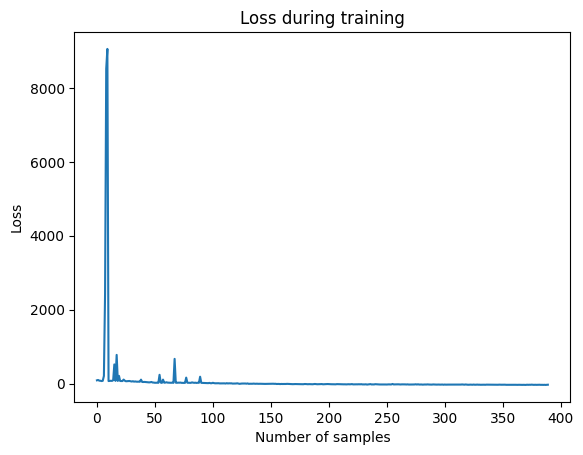

In [ ]:
nvp = RealNVP(64, 250, 8)
losses = nvp.train_inn(X_train, len(X_train), 30, lr=0.002, k=8)
plt.plot(losses)
plt.xlabel("Number of samples")
plt.ylabel("Loss")
plt.title("Loss during training")

It can be observed here that the distribution of points in code space is not too different from the previous one. The MMD is slightly different but still quite low.

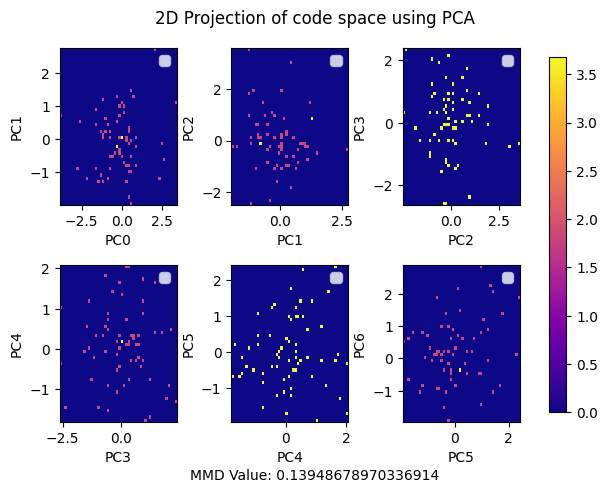

In [ ]:
code_samples, _, Qs = nvp.encode(X_test)
code_samples = np.array([c.detach().numpy() for c in code_samples])
plot_pca_projections(code_samples)

Again the forward and backward pass still works, the reconstructed images are almost identical to the original ones.

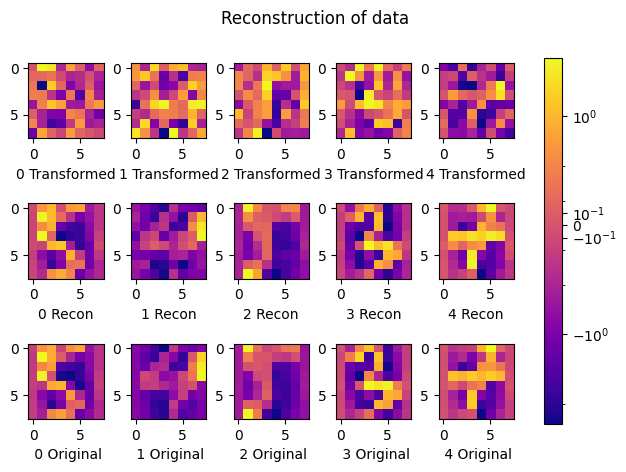

In [ ]:
plot_reconstructions(nvp, X_test)

For bottleneck size 8, the synthetic data still does resemble figures.
Mode 1: Samples from k-dimensional standard normal distribution, patted with zeros
Mode 2: First k entries of sample from 64-dimensional standard normal distribution are set to a constant (1)

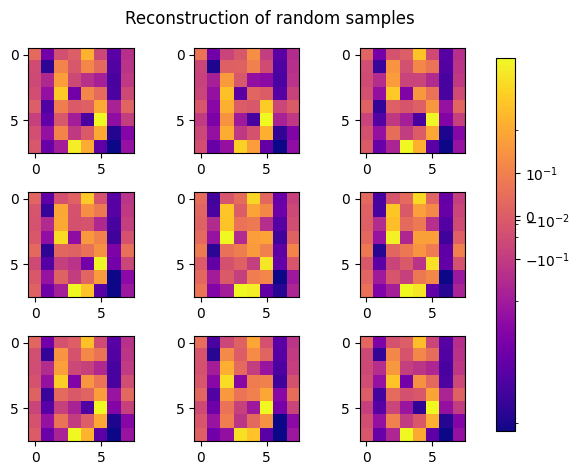

In [ ]:
plot_samples(nvp, k=8, mode=2)

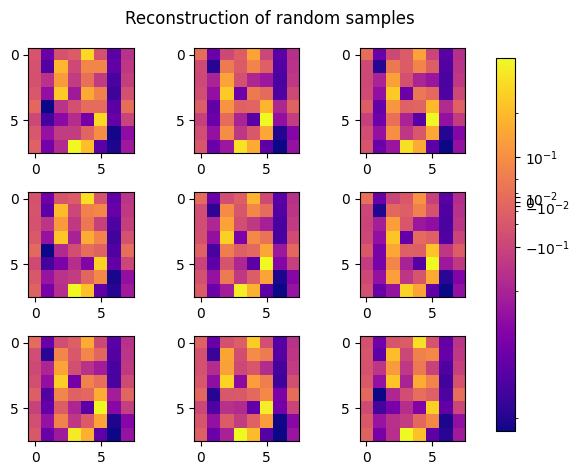

In [ ]:
plot_samples(nvp, k=8, mode=1)

### Bottleneck size 4

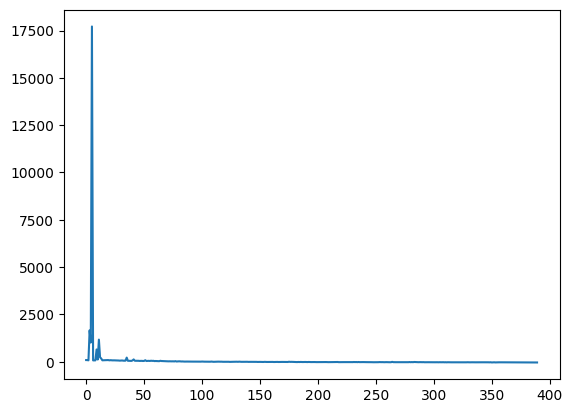

In [ ]:
nvp =  RealNVP(64, 250, 8)
losses = nvp.train_inn(X_train, len(X_train), 30, k=4, lr=0.002)
plt.plot(losses)

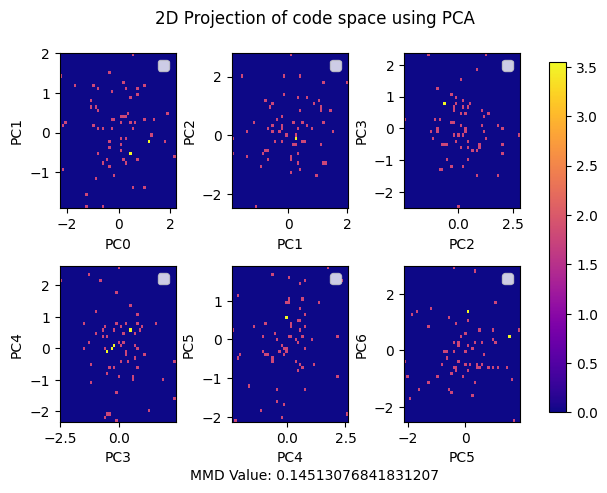

In [ ]:
code_samples, _, Qs = nvp.encode(X_test)
code_samples = np.array([c.detach().numpy() for c in code_samples])
plot_pca_projections(code_samples)

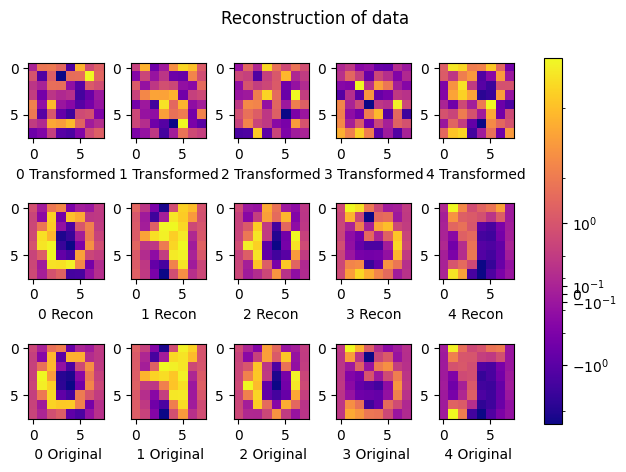

In [ ]:
plot_reconstructions(nvp, X_test)

The same experiments got repeated for bottleneck size 4, reconstruction still works and the synthetic data still  resemble any figures.

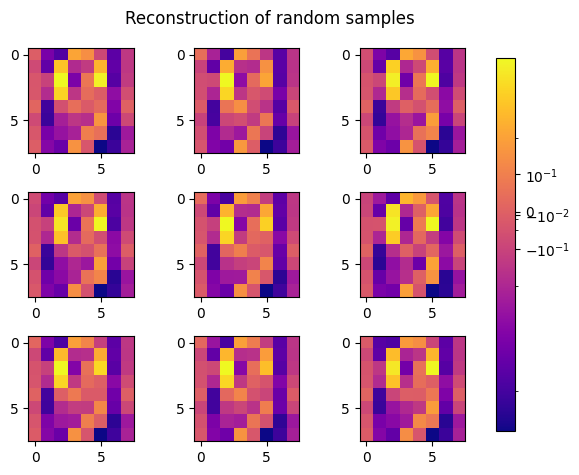

In [ ]:
plot_samples(nvp, k=4, mode=2)

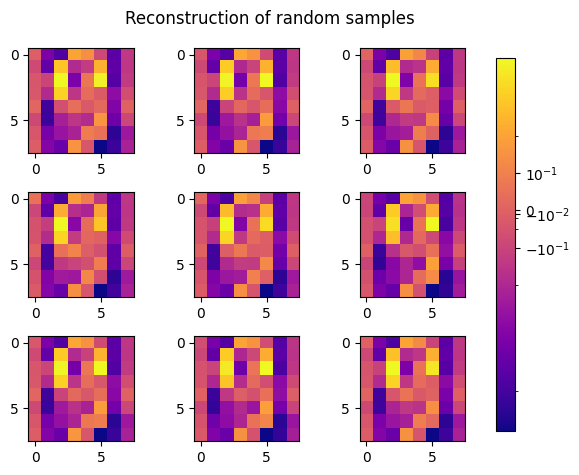

In [ ]:
plot_samples(nvp, k=4, mode=1)

### Bottleneck Size 2

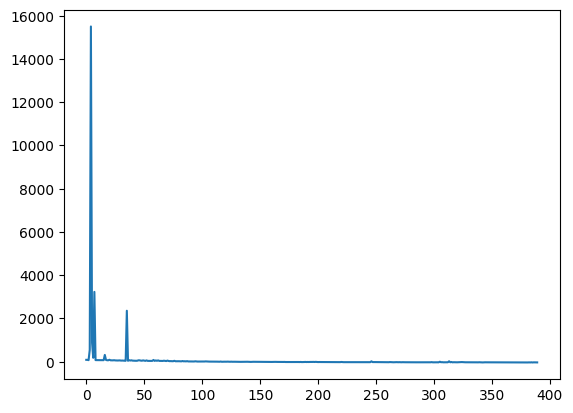

In [ ]:
nvp =  RealNVP(64, 250, 8)
losses = nvp.train_inn(X_train, len(X_train), 30, k=2, lr=0.002)
plt.plot(losses)

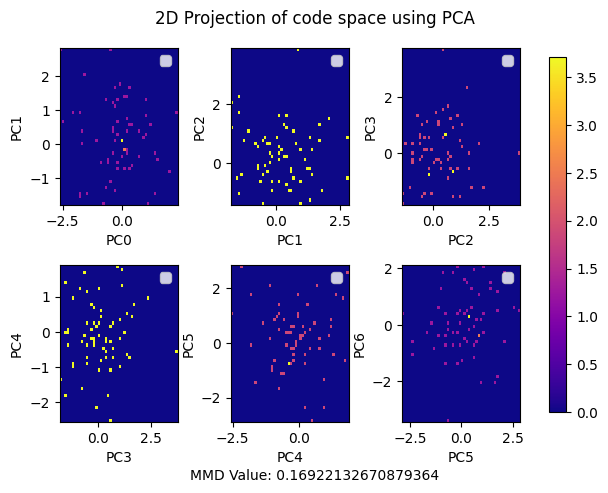

In [ ]:
code_samples, _, Qs = nvp.encode(X_test)
code_samples = np.array([c.detach().numpy() for c in code_samples])
plot_pca_projections(code_samples)

The same experiments got repeated for bottleneck size 2, reconstruction still works and the synthetic data still resemble any figures.

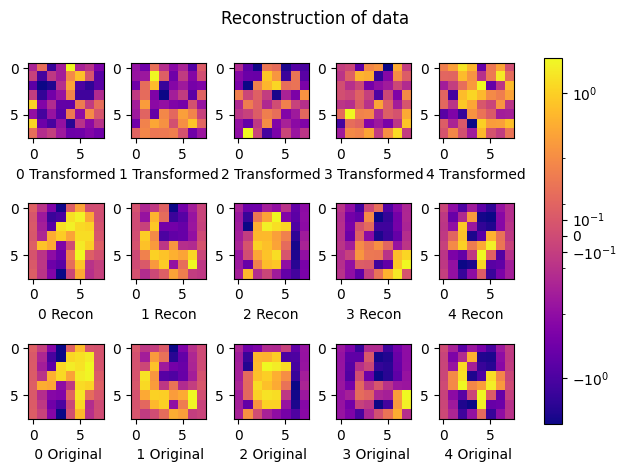

In [ ]:
plot_reconstructions(nvp, X_test)

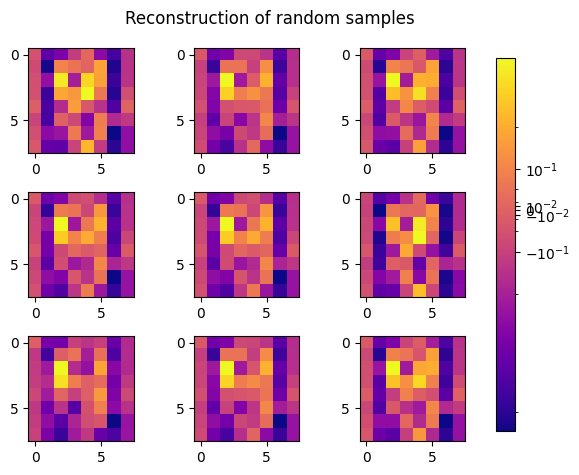

In [ ]:
plot_samples(nvp, k=2, mode=1)

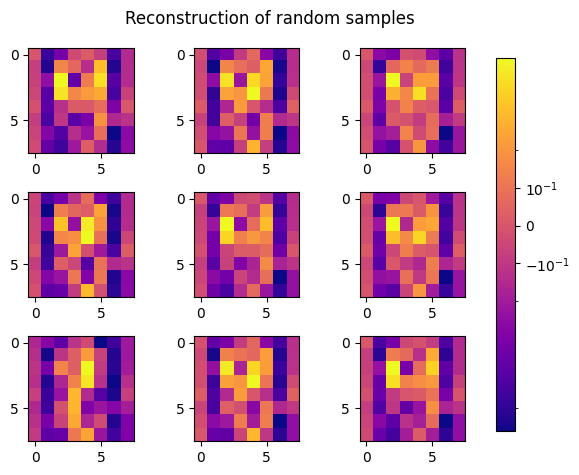

In [ ]:
plot_samples(nvp, k=2, mode=2)

Overall the described methods for generating synthetic data seem to work here.

<div style="color: green; font-weight:
bold">
Overall our synthetic data from the realNVP with bottleneck seems to be better than the ones in the provided solutions. Also here some readable digits got generated from a model, that got trained using the enitre data set, which was not achived by the worked example.</div>

3. Another possibility is to use more training data. The listing below shows how you can import the MNIST digits dataset (which consists of 6000 training instances for each label) and
downscale it to 8 × 8 on the fly. Evaluate your RealNVP on this dataset.


In [ ]:
import torch
from torchvision import datasets , transforms
from torch . utils . data import DataLoader
from PIL import Image , ImageFilter # install 'pillow ' to get PIL
import matplotlib . pyplot as plt
# define a functor to downsample images
class DownsampleTransform :
  def __init__ (self , target_shape , algorithm = Image.Resampling.LANCZOS ):
    self .width , self . height = target_shape
    self . algorithm = algorithm
  def __call__ (self , img ):
    img = img. resize (( self . width +2 , self . height +2) , self . algorithm )
    img = img. crop ((1 , 1 , self . width +1 , self . height +1) )
    return img
  # concatenate a few transforms
transform = transforms . Compose ([
DownsampleTransform ( target_shape =(8 ,8) ) ,
transforms . Grayscale ( num_output_channels =1) ,
transforms . ToTensor ()    ])
# download MNIST
mnist_dataset = datasets. MNIST( root ='./ data ', train =True ,
transform = transform , download = True )
# create a DataLoader that serves minibatches of size 100
data_loader = DataLoader ( mnist_dataset , batch_size =100 , shuffle = True )
# visualize the first batch of downsampled MNIST images
def show_first_batch ( data_loader ) :
  for batch in data_loader :
    x, y = batch
    fig = plt. figure ( figsize =(10 , 10) )
    for i, img in enumerate (x):
      ax = fig . add_subplot (10 , 10 , i +1)
      ax. imshow ( img.reshape(8 , 8) , cmap ='gray ')
      ax. axis ('off ')
    break



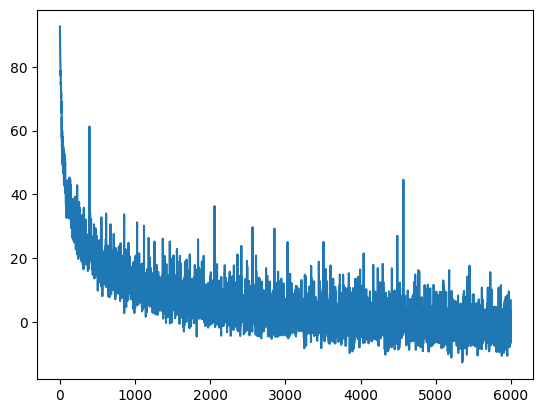

In [ ]:
nvp =  RealNVP(64, 250, 8)
losses = nvp.train_inn(data_loader, 10000, 10, lr=0.0005)
plt.plot(losses)

In [ ]:
code_samples, _, _ = nvp.encode(X_test)
code_samples = [c.detach().numpy() for c in code_samples]

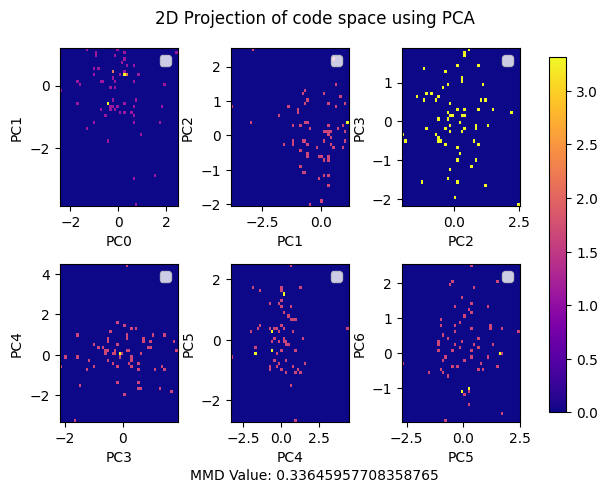

In [ ]:
plot_pca_projections(code_samples)

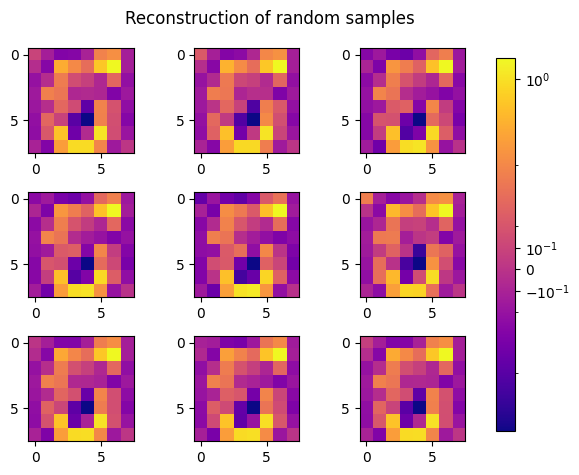

In [ ]:
plot_samples(nvp)

The most important observation is, that realNVP using a random orthonormal matrix or a random permutation matrix after each block, seems not to work here. The screenshots below show that  synthetic data is just random. It only worked after removing this part and always commuting the dimensions that get passed through the skip connections with the dimensions that get transformed.



<div style="color: green; font-weight:
bold">
The results below look similar to the result in the worked example. Our solution to this was to remove the random orthogonal matricies from the method. However this cannot be seen clearly due to the wrong implementation, caused by a communication error.  </div>

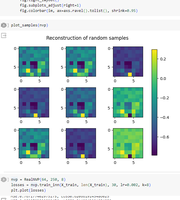

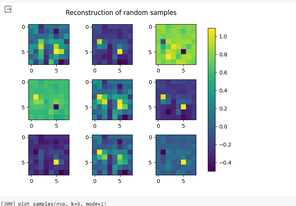

<div style="color: green; font-weight:
bold">
In general, the plots are sometimes not labeled well and the explanations are sparse at best. </div>

#Task4

Repeat task 3 with a conditional RealNVP using the digit labels as a condition. Generate data with
your model for predefined labels. Do the synthetic digits look like examples for the desired digit
label? If yes, you should again check the accuracy and confidence with a random forest classifier as
in exercise 02.

In [ ]:
import torch
from torchvision import datasets , transforms
from torch . utils . data import DataLoader
from PIL import Image , ImageFilter # install 'pillow ' to get PIL
import matplotlib . pyplot as plt
# define a functor to downsample images
class DownsampleTransform :
  def __init__ (self , target_shape , algorithm = Image.Resampling.LANCZOS ):
    self .width , self . height = target_shape
    self . algorithm = algorithm
  def __call__ (self , img ):
    img = img. resize (( self . width +2 , self . height +2) , self . algorithm )
    img = img. crop ((1 , 1 , self . width +1 , self . height +1) )
    return img
  # concatenate a few transforms
transform = transforms . Compose ([
DownsampleTransform ( target_shape =(8 ,8) ) ,
transforms . Grayscale ( num_output_channels =1) ,
transforms . ToTensor ()    ])
# download MNIST
mnist_dataset = datasets. MNIST( root ='./ data ', train =True ,
transform = transform , download = True )

def collate_fn(batch):
    x, y = zip(*batch)
    x = torch.stack([item.view(-1) for item in x], dim=0)
    return x, torch.tensor(y)

data_loader = DataLoader(mnist_dataset, batch_size=100, shuffle=True, collate_fn=collate_fn)

# create a DataLoader that serves minibatches of size 100

#data_loader = DataLoader ( mnist_dataset , batch_size =100 , shuffle = True )

# visualize the first batch of downsampled MNIST images
def show_first_batch ( data_loader ) :
  for batch in data_loader :
    x, y = batch
    fig = plt. figure ( figsize =(10 , 10) )
    for i, img in enumerate (x):
      ax = fig . add_subplot (10 , 10 , i +1)
      ax. imshow ( img.reshape(8 , 8) , cmap ='gray ')
      ax. axis ('off ')
    break



100%|██████████| 9912422/9912422 [00:00<00:00, 36701852.09it/s]


Extracting ./ data /MNIST/raw/train-images-idx3-ubyte.gz to ./ data /MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 73149573.57it/s]


Extracting ./ data /MNIST/raw/train-labels-idx1-ubyte.gz to ./ data /MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24365714.82it/s]


Extracting ./ data /MNIST/raw/t10k-images-idx3-ubyte.gz to ./ data /MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7053139.12it/s]


Extracting ./ data /MNIST/raw/t10k-labels-idx1-ubyte.gz to ./ data /MNIST/raw



In [ ]:
#model
n_labels=10
dim=64
nets = lambda: nn.Sequential(nn.Linear(dim+n_labels, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(dim+n_labels, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim))
masks = np.array([1] * 32 + [0] * 32)
masks = torch.from_numpy(np.array([masks] * 6).astype(np.float32))
for i in range(len(masks)):
  masks[i]=torch.matmul(permutation_matrix(dim),masks[i])
prior = distributions.MultivariateNormal(torch.zeros(dim), torch.eye(dim))
flow = RealNVP_condition(nets, nett, masks, prior)



In [ ]:


#train
optimizer = optim.Adam(flow.parameters(), lr=0.001)


num_epochs = 50
loss_list=[]

for epoch in range(num_epochs):
    for data in data_loader:
        inputs, labels = data
        labels=labels.long()

        conditions = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=n_labels)

        loss = -flow.log_prob(inputs.float(),conditions.float()).mean()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    loss_list.append(loss.item())

<ipython-input-21-707c5c243cd8>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conditions = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=n_labels)


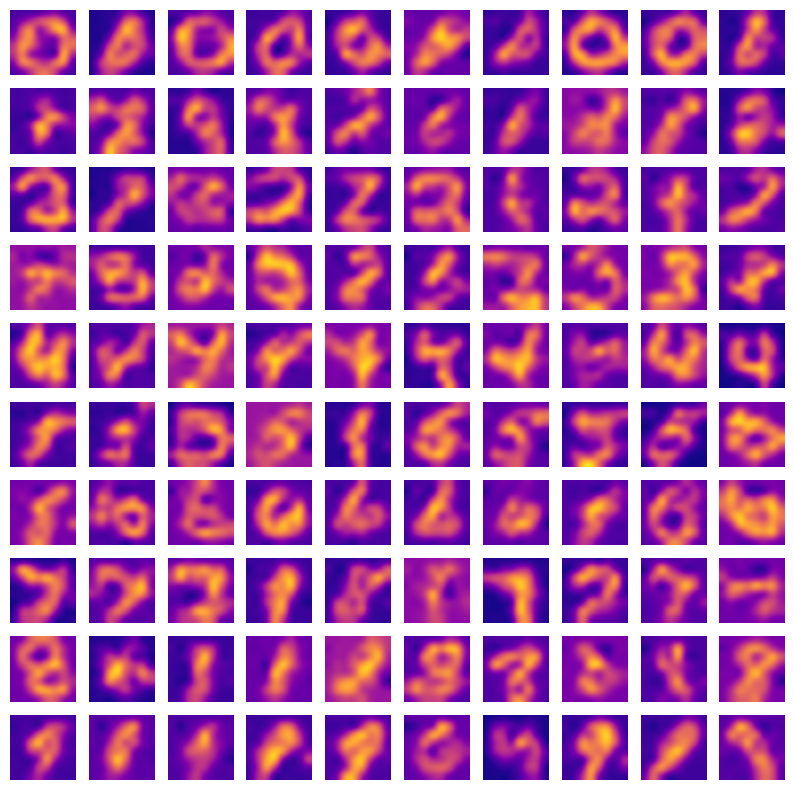

In [ ]:
#generating data
batch_size = 100
n_samples=100
condition = torch.eye(n_labels, dtype=torch.float32)
condition=torch.tile(condition.unsqueeze(0), (n_samples, 1, 1))




fig = plt.figure(figsize=(10, 10))
for i in range(10):
    samples = flow.sample(batch_size, condition[:,i,:])
    samples_reshaped = samples.view(batch_size, 8, 8)
    for j in range(10):
          ax = fig.add_subplot(10, 10, (i)*10+(j + 1))
          ax.imshow(samples_reshaped[j].detach().numpy(), cmap='plasma',interpolation='quadric')
          ax.axis('off')

plt.show()


Comments:

We used the same model with different input dimension from task 2 to train, and generated digits 0 to 9 in 10 rows. Since the pictures are only 8*8, the digits are not easy to recognize. We used quadric interpolation to make them easier to recognize, and we can see most synthetic digits look like examples for the desired digit label.